# version 13 - Middle Bluff
17.10.2025

At this notebook I'll try to remove every debud cell. I'll only keep what we need.




In [ ]:
# --- Geospatial / Geometry ---
import geopandas as gpd
from shapely.geometry import LineString, Polygon, box, Point
from shapely.ops import unary_union, substring

# Shapely union compatibility (v1 vs v2)
try:
    from shapely import union_all     # Shapely >= 2.0
except ImportError:
    from shapely.ops import unary_union as union_all  # Shapely < 2.0

# --- Data / Analysis ---
import pandas as pd
import numpy as np
from math import sqrt
import itertools
from itertools import product
import warnings
import random
from datetime import datetime

# --- Machine Learning / Statistics ---
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score
)
from scipy.stats import t as student_t

# --- Plotting ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- File paths ---
from pathlib import Path

# --- Progress bars ---
from tqdm.notebook import tqdm     # (or `from tqdm import tqdm` outside Jupyter)

# Silence unnecessary warnings if needed
#warnings.filterwarnings("ignore")


In [2]:
# ============================================================
#  Paths & CRS Setup
#  (Track-specific I/O and spatial reference configuration)
# ============================================================

# --- Track ID ---
# Change this to run the workflow for a different ground track.
TRACK_ID = "1372"

# --- Input folder ---
# Folder structure:
#   .../ATL06_all/nasa/<TRACK_ID>/filtered/*.shp or *.gpkg
input_folder = Path(
    rf"C:\coding\arctic\paper1\ATL06_all\nasa\{TRACK_ID}\filtered"
)

if not input_folder.exists():
    raise FileNotFoundError(
        f"❌ Input folder not found:\n{input_folder}"
    )

# --- Output folder ---
# Each track gets its own subfolder to avoid mixing results.
output_folder = input_folder / f"sensitivity_out_{TRACK_ID}"
output_folder.mkdir(parents=True, exist_ok=True)

# --- Coordinate Reference Systems ---
# EPSG 32606 = UTM Zone 6N, appropriate for Alaska North Slope.
UTM_EPSG = 32606

# ATL06 native CRS (lat/lon WGS84)
ORIGINAL_CRS = "EPSG:4326"

# --- Status printout ---
print("📂 Using input folder:      ", input_folder)
print("📂 Output folder created:   ", output_folder)
print("🌍 CRS settings:")
print(f"   • Original CRS    = {ORIGINAL_CRS}")
print(f"   • Processing CRS  = EPSG:{UTM_EPSG}")


📂 Using input folder:       C:\coding\arctic\paper1\ATL06_all\nasa\1372\filtered
📂 Output folder created:    C:\coding\arctic\paper1\ATL06_all\nasa\1372\filtered\sensitivity_out_1372
🌍 CRS settings:
   • Original CRS    = EPSG:4326
   • Processing CRS  = EPSG:32606


In [3]:
# ============================================================
#  Helper Functions — Extract Metadata From Filenames
# ============================================================

def extract_date_from_filename(filename: str):
    """
    Extract acquisition date (YYYYMMDD) from an ATL06 filename.

    Example:
        ATL06_0129_gt1l_20190105.shp  →  datetime(2019, 1, 5)

    Returns:
        datetime or None
    """
    stem = Path(filename).stem
    parts = stem.split("_")

    # Find 8-digit numeric tokens (YYYYMMDD)
    candidates = [p for p in parts if len(p) == 8 and p.isdigit()]
    if not candidates:
        return None

    try:
        return datetime.strptime(candidates[-1], "%Y%m%d")
    except Exception as e:
        print(f"⚠️ Date parse failed for {filename}: {e}")
        return None


def extract_gt_family(filename: str):
    """
    Extract ICESat-2 beam family: 'gt1', 'gt2', 'gt3'.

    Handles filenames containing:
        gt1l, gt1r, gt2l, gt2r, gt3l, gt3r

    Returns:
        'gt1', 'gt2', 'gt3', or None if not found.
    """
    tokens = Path(filename).stem.lower().split("_")

    for t in tokens:
        if t.startswith("gt1"): return "gt1"
        if t.startswith("gt2"): return "gt2"
        if t.startswith("gt3"): return "gt3"

    return None


def extract_track_number(filename: str):
    """
    Extract the 4-digit track number from the filename.

    Example:
        ATL06_0129_gt1l_20190105.shp → '0129'
        ATL06_20190105_01290203_007 → '0129' (handles long tokens)

    Returns:
        Track as string (e.g., '0129') or None.
    """
    stem = Path(filename).stem

    # First try exact 4-digit tokens
    for token in stem.split("_"):
        if token.isdigit() and len(token) == 4:
            return token

    # Secondary pass (for ATL03-style tokens like "_01290203_"):
    # Pull out any 4-digit substring inside a longer numeric sequence.
    digits = "".join([c if c.isdigit() else " " for c in stem]).split()
    for seq in digits:
        if len(seq) >= 4:
            return seq[:4]

    return None


In [ ]:
# ============================================================
#  Default Parameters
#  (All of these can be overridden later in sensitivity loops)
# ============================================================

# ------------------------------
# Spatial clustering parameters
# ------------------------------
CLUSTER_DISTANCE_M = 18    # Max distance (m) between points to form a cluster

# ------------------------------
# Vertical filtering parameters
# ------------------------------
VERTICAL_TOLERANCE = 5    # Absolute elevation difference threshold (m)
BIAS_TOLERANCE     = 0.5  # Acceptable bias after reference alignment (m)

# ------------------------------
# Temporal / data sufficiency
# ------------------------------
MIN_PROFILES_PER_CLUSTER = 2     # Minimum number of profiles (cycles)
MIN_POINTS_PCT = 0.8              # Beam must have >= 80% of max points in cluster

# ------------------------------
# Oriented box dimensions (UTM meters)
# ------------------------------
HALF_ALONG_M  = 300    # Half-length alongshore
HALF_ACROSS_M = 300    # Half-width cross-shore

# ------------------------------
# Ideal-case reference
# ------------------------------
N_CYCLES   = 24
IDEAL_CASE = N_CYCLES * 2      # If every cycle has 2 beams

# ------------------------------
# Elevation filtering
# ------------------------------
ELEV_TRASH = 20   # Remove any ICESat-2 elevations above this threshold (m)

# ------------------------------
# Beam separation constraint
# ------------------------------
TOO_FAR_BEAM = 46   # Beams farther apart than this are considered isolated

# ------------------------------
# Ground-track families (renamed → GTX)
# ------------------------------
GTX = ["gt1", "gt2", "gt3"]

# ------------------------------
# Status summary
# ------------------------------
print(
    "Defaults →\n"
    f"  • Cluster distance:   {CLUSTER_DISTANCE_M} m\n"
    f"  • Vertical tolerance: {VERTICAL_TOLERANCE} m\n"
    f"  • Bias tolerance:     {BIAS_TOLERANCE} m\n"
    f"  • Min profiles:       {MIN_PROFILES_PER_CLUSTER}\n"
    f"  • Min points/beam:    {MIN_POINTS_PCT * 100:.0f}%\n"
    f"  • Box dims:           {HALF_ALONG_M} × {HALF_ACROSS_M} m (along × across)\n"
    f"  • Ideal case beams:   {IDEAL_CASE}\n"
    f"  • Elevation trash:    {ELEV_TRASH} m\n"
    f"  • Too-far beam:       {TOO_FAR_BEAM} m\n"
    f"  • GTX:                {GTX}\n"
)


Defaults →
  • Cluster distance:   18 m
  • Vertical tolerance: 5 m
  • Bias tolerance:     0.5 m
  • Min profiles:       2
  • Min points/beam:    80%
  • Box dims:           300 × 700 m (along × across)
  • Ideal case beams:   48
  • Elevation trash:    20 m
  • Too-far beam:       46 m
  • GTX:                ['gt1', 'gt2', 'gt3']



# Clip data

In [5]:
# ============================================================
#  Load Shoreline Geometry
# ============================================================

# Path to shoreline shapefile
shoreline_fp = r"C:\coding\arctic\Gis\datasets\MyOwn\AOI_shoreline.shp"

# Load file
if not Path(shoreline_fp).exists():
    raise FileNotFoundError(f"❌ Shoreline file not found:\n{shoreline_fp}")

shoreline_gdf = gpd.read_file(shoreline_fp)

# --- CRS Safety Check --------------------------------------------------------
# Ensure shoreline has a valid CRS. If not, assign WGS84 by default.
if shoreline_gdf.crs is None:
    print("⚠️ Warning: shoreline file has no CRS. Assigning WGS84 (EPSG:4326).")
    shoreline_gdf = shoreline_gdf.set_crs("EPSG:4326")

print(f"🌊 Shoreline loaded: {len(shoreline_gdf)} features")
# print(f"   CRS → {shoreline_gdf.crs}")


🌊 Shoreline loaded: 1 features


In [6]:
# ============================================================
#  STEP 2 — Load ALL beams with metadata (NO filtering)
# ============================================================

def load_beams(input_folder, ORIGINAL_CRS, UTM_EPSG, verbose=True):
    """
    Read every *.shp in input_folder and attach:
        - gt_family (gt1, gt2, gt3)
        - track_id  (4-digit)
        - acq_date  (datetime)
        - year
        - beam_id   (from filename if needed)
        - file_path

    NO filtering (no cluster filter, no vertical filter).
    Returns:
        GeoDataFrame (UTM projected)
    """
    
    # All shapefiles in the folder
    files = sorted(Path(input_folder).glob("*.shp"))
    if verbose:
        print(f"📁 Found {len(files)} shapefiles")

    rows = []

    for f in files:
        try:
            gdf = gpd.read_file(f)
        except Exception as e:
            if verbose:
                print(f"[WARN] Failed to read {f.name}: {e}")
            continue

        # Must have latitude / longitude columns
        if gdf.empty or not {"latitude", "longitude"}.issubset(gdf.columns):
            if verbose:
                print(f"[INFO] Skipped (empty or missing lat/lon): {f.name}")
            continue

        # --- Set geometry + CRS safely ---
        gdf = gdf.set_geometry(
            gpd.points_from_xy(
                gdf["longitude"], gdf["latitude"], crs=ORIGINAL_CRS
            )
        )

        # Reproject to UTM
        gdf = gdf.to_crs(UTM_EPSG)

        # --- Extract metadata ---
        date_val   = extract_date_from_filename(f.name)
        fam        = extract_gt_family(f.name)
        track_val  = extract_track_number(f.name)

        gdf["gt_family"] = fam
        gdf["track_id"]  = track_val
        gdf["acq_date"]  = date_val
        gdf["year"]      = date_val.year if date_val else None

        # Ensure beam_id is stable
        gdf["beam_id"] = Path(f).stem

        # File source
        gdf["file_path"] = str(f)

        rows.append(gdf)

    if not rows:
        if verbose:
            print("⚠️ No valid ATL06 shapefiles were loaded.")
        return gpd.GeoDataFrame(columns=["geometry"],
                                crs=f"EPSG:{UTM_EPSG}")

    # Combine everything
    dataset_raw_preclip = gpd.GeoDataFrame(
        pd.concat(rows, ignore_index=True),
        crs=f"EPSG:{UTM_EPSG}"
    )

    if verbose:
        nb = dataset_raw_preclip["beam_id"].nunique()
        print(f"[RAW] Loaded beams (no filtering): {nb} unique beams")
        print(f"     Total points: {len(dataset_raw_preclip):,}")

    return dataset_raw_preclip


# --- Run beam loader ---
dataset_raw_preclip = load_beams(input_folder, ORIGINAL_CRS, UTM_EPSG, verbose=True)


📁 Found 38 shapefiles
[RAW] Loaded beams (no filtering): 38 unique beams
     Total points: 1,811


In [7]:
# ============================================================
#  Build Oriented Extraction Box for a Single Ground Track Family (GTX)
# ============================================================

def build_box_from_centroid(
        dataset_raw,
        shoreline_gdf,
        utm_epsg,
        gt_family,
        half_along=HALF_ALONG_M,
        half_across=HALF_ACROSS_M,
        verbose=False
    ):
    """
    Build an oriented extraction box around the shoreline crossing point
    for a SINGLE ground-track family (GTX).

    This function implements the *same logic* as build_boxes_for_families():

        1. Reproject dataset + shoreline to UTM
        2. Compute centroid of all beam points in this family
        3. Build LineStrings for each beam
        4. Pick beam whose line is closest to centroid
        5. Find shoreline crossing point of that beam
        6. Compute tangent + normal vectors
        7. Build oriented bounding box
        8. Clip UTM points within that box

    Returns:
        (center_pt, box_gdf, clipped_points, cross_pt, nearest_beam)
    """

    # -----------------------------------------------------------
    # Extract this GTX family
    # -----------------------------------------------------------
    fam_df = dataset_raw[dataset_raw["gt_family"] == gt_family].copy()
    if fam_df.empty:
        if verbose:
            print(f"[INFO] {gt_family}: no points found.")
        return None, None, None, None, None

    try:
        # -----------------------------------------------------------
        # Reproject family and shoreline into UTM
        # -----------------------------------------------------------
        fam_df = fam_df.to_crs(utm_epsg)
        shoreline_utm = shoreline_gdf.to_crs(utm_epsg)

        # -----------------------------------------------------------
        # Step 1: centroid of ALL points in this family
        # -----------------------------------------------------------
        center_pt = fam_df.geometry.union_all().centroid

        # -----------------------------------------------------------
        # Step 2: build LineString for each beam
        # -----------------------------------------------------------
        lines = {}

        for beam_id, g in fam_df.groupby("beam_id"):
            # At least 2 points needed to form a line
            if len(g) < 2:
                continue

            # Sort points by Y (northing) to enforce correct ordering
            g_sorted = (
                g.assign(_y=g.geometry.y)
                 .sort_values("_y")
                 .drop(columns="_y")
            )

            line = LineString(g_sorted.geometry.tolist())
            lines[beam_id] = line

        if not lines:
            if verbose:
                print(f"[INFO] {gt_family}: no valid beam lines.")
            return center_pt, None, None, None, None

        # -----------------------------------------------------------
        # Step 3: find beam whose *centroid* is closest to overall centroid
        # -----------------------------------------------------------
        nearest_beam, nearest_line = min(
            lines.items(),
            key=lambda kv: kv[1].centroid.distance(center_pt)
        )

        # -----------------------------------------------------------
        # Step 4: find crossing with shoreline
        # -----------------------------------------------------------
        shore_union = shoreline_utm.geometry.union_all()
        inter = nearest_line.intersection(shore_union)

        if inter.is_empty:
            if verbose:
                print(f"[WARN] {gt_family}: no shoreline crossing found.")
            return center_pt, None, None, None, nearest_beam

        # Determine the correct crossing geometry
        if inter.geom_type == "Point":
            cross_pt = inter
        elif inter.geom_type == "MultiPoint":
            cross_pt = min(inter.geoms, key=lambda p: p.distance(center_pt))
        else:   # LineString, GeometryCollection, etc.
            cross_pt = inter.centroid

        # -----------------------------------------------------------
        # Step 5: orientation from tangent vector
        # -----------------------------------------------------------
        p0 = nearest_line.interpolate(0.4, normalized=True)
        p1 = nearest_line.interpolate(0.6, normalized=True)

        vx, vy = (p1.x - p0.x), (p1.y - p0.y)
        norm = np.hypot(vx, vy)

        if norm == 0:
            if verbose:
                print(f"[WARN] {gt_family}: invalid tangent vector.")
            return center_pt, None, None, cross_pt, nearest_beam

        t_hat = np.array([vx, vy]) / norm        # unit tangent
        n_hat = np.array([-t_hat[1], t_hat[0]])  # unit normal

        # -----------------------------------------------------------
        # Step 6: build oriented box
        # -----------------------------------------------------------
        c = np.array([cross_pt.x, cross_pt.y])
        corners = [
            c + t_hat * half_along + n_hat * half_across,
            c - t_hat * half_along + n_hat * half_across,
            c - t_hat * half_along - n_hat * half_across,
            c + t_hat * half_along - n_hat * half_across,
        ]

        box_poly = Polygon(corners)
        box_gdf = gpd.GeoDataFrame(
            {"geometry": [box_poly]},
            crs=f"EPSG:{utm_epsg}"
        )

        # -----------------------------------------------------------
        # Step 7: clip points inside the box
        # -----------------------------------------------------------
        mask = fam_df.geometry.within(box_poly) | fam_df.geometry.touches(box_poly)
        clipped_points = fam_df.loc[mask].copy()

        # Done
        return center_pt, box_gdf, clipped_points, cross_pt, nearest_beam

    except Exception as e:
        if verbose:
            print(f"[ERROR] {gt_family}: box-build failed → {e}")
        return None, None, None, None, None


In [8]:
# # ============================================================
# #  ZOOMED view showing beams + shoreline only in the box area
# # ============================================================

# plt.figure(figsize=(12, 12))
# ax = plt.gca()

# # ---------------------------
# # Collect box bounds (NOT shoreline bounds)
# # ---------------------------
# box_bounds = []

# # ---------------------------
# # Plot beams by family
# # ---------------------------
# colors = {"gt1": "red", "gt2": "green", "gt3": "blue"}

# for fam in GTX:
#     fam_df = dataset_raw_preclip[dataset_raw_preclip["gt_family"] == fam]
#     if fam_df.empty:
#         continue

#     fam_df.plot(
#         ax=ax,
#         color=colors.get(fam, "gray"),
#         markersize=5,
#         alpha=0.5,
#         label=f"{fam} beams"
#     )

# # ---------------------------
# # Plot shoreline (will not affect zoom)
# # ---------------------------
# shoreline_utm = shoreline_gdf.to_crs(UTM_EPSG)
# shoreline_utm.plot(
#     ax=ax,
#     color="black",
#     linewidth=2,
#     label="Shoreline"
# )

# # ---------------------------
# # Plot boxes and collect bounds
# # ---------------------------
# for fam in GTX:
#     center_pt, box_gdf, clipped, cross_pt, nearest_beam = build_box_from_centroid(
#         dataset_raw_preclip,
#         shoreline_gdf,
#         UTM_EPSG,
#         fam,
#         verbose=False
#     )

#     if box_gdf is None:
#         continue

#     box_gdf.boundary.plot(ax=ax, color="orange", linewidth=2)

#     # Label box
#     bx = box_gdf.geometry.iloc[0].centroid
#     ax.text(bx.x, bx.y, fam, fontsize=12, color="orange")

#     # Save bounds for zoom
#     box_bounds.append(box_gdf.total_bounds)

# # ---------------------------
# # AUTO-ZOOM using ONLY BOX BOUNDS
# # ---------------------------
# if box_bounds:
#     bounds = np.array(box_bounds)
#     xmin = bounds[:,0].min()
#     ymin = bounds[:,1].min()
#     xmax = bounds[:,2].max()
#     ymax = bounds[:,3].max()

#     # Add padding
#     pad_x = (xmax - xmin) * 0.2
#     pad_y = (ymax - ymin) * 0.2

#     ax.set_xlim(xmin - pad_x, xmax + pad_x)
#     ax.set_ylim(ymin - pad_y, ymax + pad_y)
# else:
#     print("⚠ No boxes found — cannot zoom.")

# # ---------------------------
# # Styling
# # ---------------------------
# plt.title("Beams, Shoreline, and Extraction Boxes (ZOOMED-IN on Boxes Only)", fontsize=15)
# plt.xlabel("UTM Easting (m)")
# plt.ylabel("UTM Northing (m)")
# plt.grid(alpha=0.3)

# # Remove duplicates in legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

# plt.tight_layout()
# plt.show()


In [9]:
# ============================================================
#  Determine Middle Beam and Shoreline Crossing for a GTX
# ============================================================

def get_middle_crossing(dataset_raw, shoreline_utm, utm_epsg, gt_family):
    """
    For a given ground-track family (gt1, gt2, or gt3):

        1. Reproject family points to UTM
        2. Compute overall centroid of all beam points
        3. Build LineStrings for each beam
        4. Choose the beam whose centroid is closest to the overall centroid
        5. Compute its intersection with the shoreline (already in UTM)

    Parameters
    ----------
    dataset_raw : GeoDataFrame
        All raw ATL06 points (any CRS)
    shoreline_utm : GeoDataFrame
        Shoreline already in UTM (DO NOT reproject here)
    utm_epsg : int
        EPSG code for UTM projection
    gt_family : str
        'gt1', 'gt2', or 'gt3'

    Returns
    -------
    center_pt     : shapely Point
        Centroid of all beam points in this family
    cross_pt      : shapely Point or None
        Intersection with shoreline, or None if no crossing
    nearest_beam  : str
        Beam_id of the beam closest to the centroid
    nearest_line  : shapely LineString
        Beam line used for computing crossing
    """

    # -----------------------------------------------------------
    # Extract the selected GTX family
    # -----------------------------------------------------------
    fam_df = dataset_raw[dataset_raw["gt_family"] == gt_family].copy()
    if fam_df.empty:
        return None, None, None, None

    # Reproject family to UTM
    fam_df = fam_df.to_crs(utm_epsg)

    # -----------------------------------------------------------
    # Step 1: Compute centroid of ALL beam points in this GTX
    # -----------------------------------------------------------
    center_pt = fam_df.geometry.union_all().centroid

    # -----------------------------------------------------------
    # Step 2: Construct LineStrings for each beam
    # -----------------------------------------------------------
    lines = {}
    for beam_id, g in fam_df.groupby("beam_id"):
        if len(g) < 2:
            continue

        # Sort points by northing to produce an ordered LineString
        g_sorted = (
            g.assign(_y=g.geometry.y)
             .sort_values("_y")
             .drop(columns="_y")
        )
        line = LineString(g_sorted.geometry.tolist())
        lines[beam_id] = line

    if not lines:
        # No valid beam lines available
        return center_pt, None, None, None

    # -----------------------------------------------------------
    # Step 3: Select the beam closest to the centroid
    # -----------------------------------------------------------
    nearest_beam, nearest_line = min(
        lines.items(),
        key=lambda kv: kv[1].centroid.distance(center_pt)
    )

    # -----------------------------------------------------------
    # Step 4: Compute intersection with shoreline
    # -----------------------------------------------------------
    shore_union = shoreline_utm.geometry.union_all()
    inter = nearest_line.intersection(shore_union)

    if inter.is_empty:
        cross_pt = None
    elif inter.geom_type == "Point":
        cross_pt = inter
    elif inter.geom_type == "MultiPoint":
        # Choose the point closest to the family centroid
        cross_pt = min(inter.geoms, key=lambda p: p.distance(center_pt))
    else:
        # For LineString or mixed geometries
        cross_pt = inter.centroid

    # -----------------------------------------------------------
    # Return results
    # -----------------------------------------------------------
    return center_pt, cross_pt, nearest_beam, nearest_line


In [10]:
# ============================================================
#  Build Oriented Extraction Boxes for ALL GTX Families
# ============================================================

def build_boxes_for_families(dataset_raw, shoreline_gdf,
                             utm_epsg=UTM_EPSG,
                             half_along=HALF_ALONG_M,
                             half_across=HALF_ACROSS_M,
                             verbose=True):
    """
    Correct version — ensures:
        1. TRUE shoreline crossing (offshore zero point)
        2. Oriented box built from crossing point, not centroid
        3. distance_from_offshore computed in UTM (meters)

    Returns
    -------
    dict:
        fam: {
            "box": box_gdf,
            "clipped": clipped_points,
            "cross": shoreline_cross_point,
            "center": centroid_of_family,
            "nearest_beam": beam_id
        }
    """
    
    dataset_clean = {}

    # Reproject shoreline once (saves time)
    shoreline_utm = shoreline_gdf.to_crs(utm_epsg)

    # Loop through ground track families
    for fam in GTX:

        fam_df = dataset_raw[dataset_raw["gt_family"] == fam].copy()
        if fam_df.empty:
            if verbose:
                print(f"[INFO] {fam}: no points found.")
            continue

        # Reproject beam points to UTM
        fam_df = fam_df.to_crs(utm_epsg)

        # -------- 1) TRUE shoreline crossing point ----------------
        center_pt, cross_pt, nearest_beam, nearest_line = \
            get_middle_crossing(dataset_raw, shoreline_utm, utm_epsg, fam)

        if cross_pt is None:
            if verbose:
                print(f"[WARN] {fam}: no shoreline crossing found.")
            continue

        # -------- 2) Orientation from beam tangent ----------------
        p0 = nearest_line.interpolate(0.4, normalized=True)
        p1 = nearest_line.interpolate(0.6, normalized=True)

        vx, vy = p1.x - p0.x, p1.y - p0.y
        norm = np.hypot(vx, vy)
        if norm == 0:
            if verbose:
                print(f"[WARN] {fam}: invalid tangent vector.")
            continue

        t_hat = np.array([vx, vy]) / norm
        n_hat = np.array([-t_hat[1], t_hat[0]])

        # -------- 3) Build oriented box from TRUE offshore point --
        C = np.array([cross_pt.x, cross_pt.y])
        corners = [
            C + t_hat * half_along + n_hat * half_across,
            C - t_hat * half_along + n_hat * half_across,
            C - t_hat * half_along - n_hat * half_across,
            C + t_hat * half_along - n_hat * half_across,
        ]
        box_poly = Polygon(corners)
        box_gdf = gpd.GeoDataFrame({"geometry": [box_poly]},
                                   crs=f"EPSG:{utm_epsg}")

        # -------- 4) Clip beams inside the oriented box ----------
        mask = fam_df.geometry.within(box_poly) | fam_df.geometry.touches(box_poly)
        clipped = fam_df.loc[mask].copy()

        # If there are no clipped points, skip
        if clipped.empty:
            if verbose:
                print(f"[WARN] {fam}: no clipped points inside box.")
            continue

        # -------- 5) Compute TRUE offshore distances -------------
        cx, cy = cross_pt.x, cross_pt.y
        clipped["distance_from_offshore"] = clipped.geometry.apply(
            lambda p: np.hypot(p.x - cx, p.y - cy)
        )

        # -------- Save results -----------------------------------
        dataset_clean[fam] = {
            "box": box_gdf,
            "clipped": clipped,
            "cross": cross_pt,
            "center": center_pt,
            "nearest_beam": nearest_beam
        }

        if verbose:
            print(f"[OK] {fam}: box built with {len(clipped)} clipped points.")

    return dataset_clean


In [11]:
dataset_clean = build_boxes_for_families(
    dataset_raw_preclip,
    shoreline_gdf,
    utm_epsg=UTM_EPSG,
    half_along=HALF_ALONG_M,
    half_across=HALF_ACROSS_M,
    verbose=False
)

# Recompute distance from Offshore

In [12]:
def compute_distances(dataset_clean, utm_epsg=UTM_EPSG):
    """
    Correct version:
    • Sort each beam from offshore → inland using y-coordinate
    • distance_from_offshore = cumulative along-track distance
    • No Euclidean distance to shoreline crossing
    """

    rows = []

    for fam, content in dataset_clean.items():

        clipped = content.get("clipped")
        if clipped is None or clipped.empty:
            continue

        gdf = clipped.to_crs(utm_epsg).copy()

        for bid, g in gdf.groupby("beam_id"):

            if len(g) < 2:
                continue

            # offshore → inland sorting (northernmost first)
            g = g.assign(_y=g.geometry.y).sort_values("_y", ascending=False).drop(columns="_y")

            # cumulative along-track
            xy = np.array([(p.x, p.y) for p in g.geometry])
            seg = np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1))
            dist = np.concatenate(([0.0], np.cumsum(seg)))

            out = g.copy()
            out["point_id"] = np.arange(len(out))
            out["distance_from_offshore"] = dist  # <-- KEY FIX
            out["alongtrack_distance"] = dist     # (same value)

            if "acq_date" in out.columns:
                out["acq_date"] = pd.to_datetime(out["acq_date"], errors="coerce")

            keep = [
                "gt_family","beam_id","track_id","acq_date",
                "point_id","distance_from_offshore",
                "alongtrack_distance","h_li","geometry"
            ]
            out = out[[c for c in keep if c in out.columns]]

            rows.append(out)

    if not rows:
        return gpd.GeoDataFrame(crs=f"EPSG:{utm_epsg}")

    return gpd.GeoDataFrame(pd.concat(rows, ignore_index=True),
                            crs=f"EPSG:{utm_epsg}")
dataset_clipped = compute_distances(dataset_clean, utm_epsg=UTM_EPSG)

# Preprocessing

In [13]:
# --- STEP 5: Apply preprocessing constraints ON THE CLIPPED DATA -------------
def apply_preprocessing_to_clipped(
        dataset_clipped,
        MIN_POINTS_PCT=MIN_POINTS_PCT,
        ELEV_TRASH=ELEV_TRASH,
        TOO_FAR_BEAM=TOO_FAR_BEAM,
        return_skipped=True,
        verbose=True):

    """
    Apply preprocessing constraints to *already clipped* beams:

      • few_points    → beam has < MIN_POINTS_PCT of family mean #
      • elev_trash    → beam contains any h_li > ELEV_TRASH
      • too_far       → beam's median point too far from neighbor (> TOO_FAR_BEAM)

    Priority (highest → lowest):
        elev_trash > few_points > too_far > loaded

    Returns
    -------
    dataset_raw : GeoDataFrame
        Only beams that pass all constraints.

    summary_raw : DataFrame
        Per-family counts: ideal_case, files_found, missing,
        elev_trash, few_points, too_far, loaded.

    flagged_df : DataFrame
        Records for beams flagged 'too_far', including nearest_dist.
    """

    # --------------------------------------------------------------------------
    # 0) Handle empty input
    # --------------------------------------------------------------------------
    if dataset_clipped is None or dataset_clipped.empty:
        empty = gpd.GeoDataFrame(columns=["geometry"],
                                 crs=getattr(dataset_clipped, "crs", None))
        return (empty, pd.DataFrame(), pd.DataFrame()) if return_skipped else empty

    gdf = dataset_clipped.copy()

    # --------------------------------------------------------------------------
    # A) Compute family-average points AFTER clipping
    # --------------------------------------------------------------------------
    fam_mean_pts = (
        gdf.groupby(["gt_family", "beam_id"])
           .size()
           .groupby("gt_family")
           .mean()
           .to_dict()
    )

    # --------------------------------------------------------------------------
    # B) Beam-level flags (few_points, elev_trash)
    # --------------------------------------------------------------------------
    beams_info = []

    for (fam, bid), bdf in gdf.groupby(["gt_family", "beam_id"]):

        # few_points: ratio to family mean # of points
        fam_avg = fam_mean_pts.get(fam, np.nan)
        few_points_flag = (
            np.isfinite(fam_avg) and fam_avg > 0 and (len(bdf) / fam_avg < MIN_POINTS_PCT)
        )

        # elevation trash
        # elev_flag = ("h_li" in bdf.columns) and (bdf["h_li"] > ELEV_TRASH).any()

        # elevation trash: remove beams with extreme high OR low elevations
        elev_flag = (
            "h_li" in bdf.columns
            and (
                (bdf["h_li"] > ELEV_TRASH).any()
                or (bdf["h_li"] < -ELEV_TRASH).any()        
            )
        )

        beams_info.append({
            "gt_family": fam,
            "beam_id": bid,
            "few_points": few_points_flag,
            "elev_trash": elev_flag
        })

    beam_flags = pd.DataFrame(beams_info)

    # --------------------------------------------------------------------------
    # C) too_far flag via median XY per beam within each gt_family
    # --------------------------------------------------------------------------
    flagged_records = []
    beam_flags["nearest_dist"] = np.nan
    beam_flags["too_far"] = False

    for fam, sub in gdf.groupby("gt_family"):

        # compute median XY of *clipped* points for each beam
        med_xy = sub.groupby("beam_id")["geometry"].apply(
            lambda s: Point(np.median(s.x), np.median(s.y))
        )

        if med_xy.shape[0] < 2:
            continue

        med_gdf = gpd.GeoDataFrame(
            {"beam_id": med_xy.index, "geometry": med_xy},
            geometry="geometry",
            crs=gdf.crs
        )

        # nearest neighbor distances
        coords = np.array([[p.x, p.y] for p in med_xy])
        nbrs = NearestNeighbors(n_neighbors=2).fit(coords)
        dist, _ = nbrs.kneighbors(coords)

        med_gdf["nearest_dist"] = dist[:, 1]
        med_gdf["too_far"] = med_gdf["nearest_dist"] > TOO_FAR_BEAM

        for _, row in med_gdf.iterrows():
            sel = (beam_flags.gt_family == fam) & (beam_flags.beam_id == row.beam_id)
            beam_flags.loc[sel, "nearest_dist"] = float(row.nearest_dist)
            beam_flags.loc[sel, "too_far"] = bool(row.too_far)

            if row.too_far:
                flagged_records.append({
                    "gt_family": fam,
                    "beam_id": row.beam_id,
                    "nearest_dist": float(row.nearest_dist)
                })

    flagged_df = pd.DataFrame(flagged_records)

    # --------------------------------------------------------------------------
    # D) Final beam status: elev_trash > few_points > too_far > loaded
    # --------------------------------------------------------------------------
    def classify(row):
        if row.elev_trash:
            return "elev_trash"
        if row.few_points:
            return "few_points"
        if row.too_far:
            return "too_far"
        return "loaded"

    beam_flags["status"] = beam_flags.apply(classify, axis=1)

    # Kept beams
    kept = set(beam_flags.loc[beam_flags.status == "loaded", "beam_id"])

    dataset_raw = gdf[gdf["beam_id"].isin(kept)].copy()

    # --------------------------------------------------------------------------
    # E) Summary table (same structure as your older workflow)
    # --------------------------------------------------------------------------
    summary = (
        beam_flags.groupby(["gt_family", "status"])
                  .size()
                  .unstack(fill_value=0)
    )

    # files_found = unique beams per family after clipping
    summary["files_found"] = beam_flags.groupby("gt_family")["beam_id"].nunique()
    summary["ideal_case"] = IDEAL_CASE
    summary["missing"] = summary["ideal_case"] - summary["files_found"]

    # enforce column order
    col_order = [
        "ideal_case", "files_found", "missing",
        "elev_trash", "few_points", "too_far", "loaded"
    ]
    for col in col_order:
        if col not in summary:
            summary[col] = 0

    summary_raw = summary[col_order].copy()

    if verbose:
        print(f"✅ Kept {len(kept)} beams after preprocessing constraints")
        display(summary_raw)

    return (dataset_raw, summary_raw, flagged_df) if return_skipped else (dataset_raw, summary_raw)

dataset_raw, summary_raw, flagged_df = apply_preprocessing_to_clipped(
    dataset_clipped,
    MIN_POINTS_PCT=MIN_POINTS_PCT,
    ELEV_TRASH=ELEV_TRASH,
    TOO_FAR_BEAM=TOO_FAR_BEAM,
    return_skipped=True,
    verbose=False
)


## Compute distance

In [14]:
def compute_beam_distances(dataset_clean,
                           pts_gdf=None,
                           utm_epsg=UTM_EPSG):
    """
    Compute east–west (x-direction) beam spacing inside each GTX family's box.

    Parameters
    ----------
    dataset_clean : dict
        Output from build_boxes_for_families().
    pts_gdf : GeoDataFrame or None
        = None → use clipped points (content["clipped"])
        = GeoDataFrame → typically dataset_raw (kept beams)
    utm_epsg : int
        UTM EPSG code (meters)

    Returns
    -------
    beam_midpoints : GeoDataFrame   (one midpoint per beam)
    dist_summary   : DataFrame      (max_dist, avg_dist, west/east beam)
    """

    target_crs = f"EPSG:{utm_epsg}"
    midpoints = []

    # ----------------------------------------------------------------------
    # Loop over GTX families in dataset_clean
    # ----------------------------------------------------------------------
    for fam, content in dataset_clean.items():

        if not content or content.get("box") is None:
            continue

        box_gdf = content["box"]
        box_crs = str(box_gdf.crs)
        box = box_gdf.to_crs(utm_epsg) if box_crs != target_crs else box_gdf
        box_geom = box.geometry.iloc[0]

        # ------------------------------------------------------
        # Select points
        # ------------------------------------------------------
        if pts_gdf is None:
            fam_df = content.get("clipped")
        else:
            fam_df = pts_gdf.loc[pts_gdf["gt_family"] == fam]

        if fam_df is None or fam_df.empty:
            continue

        # CRS fix
        if fam_df.crs is None or str(fam_df.crs) != target_crs:
            fam_df = fam_df.to_crs(utm_epsg)

        # Only consider points inside or touching the box
        fam_df = fam_df[
            fam_df.geometry.within(box_geom) |
            fam_df.geometry.touches(box_geom)
        ]

        if fam_df.empty:
            continue

        # ------------------------------------------------------
        # Build a midpoint for each beam
        # ------------------------------------------------------
        for bid, g in fam_df.groupby("beam_id"):

            if len(g) < 2:
                continue

            # Sort along-track (Y direction)
            g_sorted = (
                g.assign(_y=g.geometry.y)
                 .sort_values("_y")
                 .drop(columns="_y")
            )

            line = LineString(g_sorted.geometry.values)
            if line.length == 0:
                continue

            # midpoint using normalized length
            midpoint = line.interpolate(0.5, normalized=True)

            midpoints.append({
                "gt_family": fam,
                "beam_id": bid,
                "geometry": midpoint
            })

    # ----------------------------------------------------------------------
    # No midpoints?
    # ----------------------------------------------------------------------
    if not midpoints:
        return (
            gpd.GeoDataFrame(columns=["gt_family", "beam_id", "geometry"], crs=target_crs),
            pd.DataFrame(columns=["gt_family", "n_beams", "max_dist", "avg_dist", "west_beam", "east_beam"])
        )

    beam_midpoints = gpd.GeoDataFrame(midpoints, crs=target_crs)

    # ----------------------------------------------------------------------
    # Build spacing summary per family
    # ----------------------------------------------------------------------
    rows = []

    for fam, fam_df in beam_midpoints.groupby("gt_family"):

        if fam_df.shape[0] < 2:
            continue

        fam_df = fam_df.assign(x=fam_df.geometry.x).sort_values("x")
        xvals = fam_df["x"].to_numpy()
        adj = np.diff(xvals)

        rows.append({
            "gt_family": fam,
            "n_beams": len(fam_df),
            "max_dist": float(xvals[-1] - xvals[0]),
            "avg_dist": float(adj.mean()) if len(adj) else np.nan,
            "west_beam": fam_df.iloc[0]["beam_id"],
            "east_beam": fam_df.iloc[-1]["beam_id"]
        })

    dist_summary = pd.DataFrame(rows)

    return beam_midpoints, dist_summary


# Create Cluster

In [15]:
# def make_clusters(dataset_clean,
#                   CLUSTER_DISTANCE_M,
#                   pts_gdf=None,
#                   min_beams=2,
#                   utm_epsg=UTM_EPSG):
#     """
#     Create clusters of beams for each GTX family using buffered centerlines.
#     Each beam becomes a polygon (buffer), and clusters are defined by
#     intersecting polygons.

#     Parameters
#     ----------
#     dataset_clean : dict
#         From build_boxes_for_families().
#     CLUSTER_DISTANCE_M : float
#         Buffer diameter.
#     pts_gdf : GeoDataFrame or None
#         If provided → use kept points (dataset_raw).
#         If None     → use clipped points (content["clipped"]).
#     min_beams : int
#         Minimum number of beams required in a cluster.
#     utm_epsg : int
#         CRS for distance calculations.

#     Returns
#     -------
#     clusters_gdf : GeoDataFrame with columns:
#         gt_family, beam_id, num_points, cluster_distance_m,
#         cluster_id, beam_ids, num_beams, geometry
#     """

#     target_crs = f"EPSG:{utm_epsg}"
#     clusters = []
#     beam_lines = {}

#     cluster_id_counter = 1

#     # ----------------------------------------------------------------------
#     # Loop over GTX families
#     # ----------------------------------------------------------------------
#     for fam, content in dataset_clean.items():

#         if not content or content.get("box") is None:
#             continue

#         # The oriented box for this family
#         box_gdf = content["box"]
#         box = box_gdf.to_crs(utm_epsg) if str(box_gdf.crs) != target_crs else box_gdf
#         box_geom = box.geometry.iloc[0]

#         # Select data source
#         if pts_gdf is not None:
#             fam_pts = pts_gdf.loc[pts_gdf["gt_family"] == fam].copy()
#         else:
#             fam_pts = content.get("clipped", gpd.GeoDataFrame()).copy()

#         if fam_pts.empty:
#             continue

#         # CRS harmonization
#         if fam_pts.crs is None or str(fam_pts.crs) != target_crs:
#             fam_pts = fam_pts.to_crs(utm_epsg)

#         # Keep only points inside/touching box
#         fam_pts = fam_pts[
#             fam_pts.geometry.within(box_geom) |
#             fam_pts.geometry.touches(box_geom)
#         ]

#         if fam_pts.empty:
#             continue

#         # ------------------------------------------------------------------
#         # Build centerlines per beam
#         # ------------------------------------------------------------------
#         for beam_id, g in fam_pts.groupby("beam_id"):

#             if len(g) < 2:
#                 continue

#             g_sorted = (
#                 g.assign(_y=g.geometry.y)
#                  .sort_values("_y")
#                  .drop(columns="_y")
#             )

#             line = LineString(g_sorted.geometry.values)
#             if line.length == 0:
#                 continue

#             # store the centerline
#             key = (fam, beam_id)
#             beam_lines[key] = line

#             # cluster polygon = buffer around centerline
#             poly = line.buffer(CLUSTER_DISTANCE_M / 2)

#             clusters.append(
#                 gpd.GeoDataFrame(
#                     {
#                         "gt_family": [fam],
#                         "beam_id": [beam_id],
#                         "num_points": [len(g)],
#                         "cluster_distance_m": [CLUSTER_DISTANCE_M],
#                         "cluster_id": [cluster_id_counter],
#                     },
#                     geometry=[poly],
#                     crs=target_crs,
#                 )
#             )

#             cluster_id_counter += 1

#     # ----------------------------------------------------------------------
#     # No clusters found?
#     # ----------------------------------------------------------------------
#     if not clusters:
#         return gpd.GeoDataFrame(columns=["cluster_id"], crs=target_crs)

#     clusters_gdf = gpd.GeoDataFrame(
#         pd.concat(clusters, ignore_index=True),
#         crs=target_crs
#     )

#     # ----------------------------------------------------------------------
#     # Build beam centerlines GeoDataFrame
#     # ----------------------------------------------------------------------
#     if beam_lines:
#         beam_gdf = gpd.GeoDataFrame(
#             {
#                 "fam_beam": list(beam_lines.keys()),
#                 "gt_family": [fb[0] for fb in beam_lines.keys()],
#                 "beam_id": [fb[1] for fb in beam_lines.keys()],
#             },
#             geometry=list(beam_lines.values()),
#             crs=target_crs,
#         )
#     else:
#         beam_gdf = gpd.GeoDataFrame(
#             columns=["fam_beam", "gt_family", "beam_id", "geometry"],
#             crs=target_crs
#         )

#     # ----------------------------------------------------------------------
#     # Count beams intersecting each buffer (cluster polygon)
#     # ----------------------------------------------------------------------
#     clusters_gdf["beam_ids"] = [
#         beam_gdf.loc[beam_gdf.intersects(poly.geometry), "fam_beam"].tolist()
#         for _, poly in clusters_gdf.iterrows()
#     ]
#     clusters_gdf["num_beams"] = clusters_gdf["beam_ids"].apply(len)

#     # ----------------------------------------------------------------------
#     # Optional filter by required minimum beams
#     # ----------------------------------------------------------------------
#     if isinstance(min_beams, (int, np.integer)) and min_beams > 1:
#         clusters_gdf = clusters_gdf.loc[
#             clusters_gdf["num_beams"] >= min_beams
#         ].copy()

#     return clusters_gdf, beam_gdf

# clusters_gdf, beam_gdf = make_clusters(
#     dataset_clean,
#     CLUSTER_DISTANCE_M,
#     pts_gdf=dataset_raw,
#     min_beams=2,
# )

In [16]:
def make_clusters(dataset_clean,
                  CLUSTER_DISTANCE_M,
                  pts_gdf=None,
                  min_beams=2,
                  utm_epsg=UTM_EPSG):
    """
    Create clusters of beams for each GTX family using buffered centerlines.
    Each beam becomes a polygon (buffer), and clusters are defined by
    intersecting polygons.

    Adds cluster center coordinates (lat/lon) as intrinsic geometry.
    """

    target_crs = f"EPSG:{utm_epsg}"
    clusters = []
    beam_lines = {}

    cluster_id_counter = 1

    # ----------------------------------------------------------------------
    # Loop over GTX families
    # ----------------------------------------------------------------------
    for fam, content in dataset_clean.items():

        if not content or content.get("box") is None:
            continue

        # The oriented box for this family
        box_gdf = content["box"]
        box = box_gdf.to_crs(utm_epsg) if str(box_gdf.crs) != target_crs else box_gdf
        box_geom = box.geometry.iloc[0]

        # Select data source
        if pts_gdf is not None:
            fam_pts = pts_gdf.loc[pts_gdf["gt_family"] == fam].copy()
        else:
            fam_pts = content.get("clipped", gpd.GeoDataFrame()).copy()

        if fam_pts.empty:
            continue

        # CRS harmonization
        if fam_pts.crs is None or str(fam_pts.crs) != target_crs:
            fam_pts = fam_pts.to_crs(utm_epsg)

        # Keep only points inside/touching box
        fam_pts = fam_pts[
            fam_pts.geometry.within(box_geom) |
            fam_pts.geometry.touches(box_geom)
        ]

        if fam_pts.empty:
            continue

        # ------------------------------------------------------------------
        # Build centerlines per beam
        # ------------------------------------------------------------------
        for beam_id, g in fam_pts.groupby("beam_id"):

            if len(g) < 2:
                continue

            g_sorted = (
                g.assign(_y=g.geometry.y)
                 .sort_values("_y")
                 .drop(columns="_y")
            )

            line = LineString(g_sorted.geometry.values)
            if line.length == 0:
                continue

            # store the centerline
            key = (fam, beam_id)
            beam_lines[key] = line

            # cluster polygon = buffer around centerline
            poly = line.buffer(CLUSTER_DISTANCE_M / 2)

            clusters.append(
                gpd.GeoDataFrame(
                    {
                        "gt_family": [fam],
                        "beam_id": [beam_id],
                        "num_points": [len(g)],
                        "cluster_distance_m": [CLUSTER_DISTANCE_M],
                        "cluster_id": [cluster_id_counter],
                    },
                    geometry=[poly],
                    crs=target_crs,
                )
            )

            cluster_id_counter += 1

    # ----------------------------------------------------------------------
    # No clusters found?
    # ----------------------------------------------------------------------
    if not clusters:
        return gpd.GeoDataFrame(columns=["cluster_id"], crs=target_crs), \
               gpd.GeoDataFrame(columns=["gt_family","beam_id","geometry"], crs=target_crs)

    clusters_gdf = gpd.GeoDataFrame(
        pd.concat(clusters, ignore_index=True),
        crs=target_crs
    )

    # ----------------------------------------------------------------------
    # Build beam centerlines GeoDataFrame
    # ----------------------------------------------------------------------
    if beam_lines:
        beam_gdf = gpd.GeoDataFrame(
            {
                "fam_beam": list(beam_lines.keys()),
                "gt_family": [fb[0] for fb in beam_lines.keys()],
                "beam_id": [fb[1] for fb in beam_lines.keys()],
            },
            geometry=list(beam_lines.values()),
            crs=target_crs,
        )
    else:
        beam_gdf = gpd.GeoDataFrame(
            columns=["fam_beam", "gt_family", "beam_id", "geometry"],
            crs=target_crs
        )

    # ----------------------------------------------------------------------
    # Count beams intersecting each buffer (cluster polygon)
    # ----------------------------------------------------------------------
    clusters_gdf["beam_ids"] = [
        beam_gdf.loc[beam_gdf.intersects(poly.geometry), "fam_beam"].tolist()
        for _, poly in clusters_gdf.iterrows()
    ]
    clusters_gdf["num_beams"] = clusters_gdf["beam_ids"].apply(len)

    # ----------------------------------------------------------------------
    # Optional filter by required minimum beams
    # ----------------------------------------------------------------------
    if isinstance(min_beams, (int, np.integer)) and min_beams > 1:
        clusters_gdf = clusters_gdf.loc[
            clusters_gdf["num_beams"] >= min_beams
        ].copy()

    # ----------------------------------------------------------------------
    # ✅ ADD CLUSTER CENTER COORDINATES (LAT / LON)
    # ----------------------------------------------------------------------
    # Centroid in UTM (stable)
    clusters_gdf["cluster_center"] = clusters_gdf.geometry.centroid

    # Convert centroids to geographic coordinates
    centers_ll = (
        clusters_gdf.set_geometry("cluster_center")
                    .to_crs(4326)
    )

    clusters_gdf["center_lon"] = centers_ll.geometry.x
    clusters_gdf["center_lat"] = centers_ll.geometry.y

    # Restore original geometry column
    clusters_gdf = clusters_gdf.set_geometry("geometry")

    return clusters_gdf, beam_gdf


In [17]:
clusters_gdf, beam_gdf = make_clusters(
    dataset_clean,
    CLUSTER_DISTANCE_M,
    pts_gdf=dataset_raw,
    min_beams=2,
)

ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

In [ ]:
# clusters_gdf.head()

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points


# -----------------------------------------------------------
# Angle between vectors (acute, 0–90°)
# -----------------------------------------------------------
def angle_between(v1, v2):
    dot = np.dot(v1, v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    if denom == 0:
        return np.nan

    cosang = np.clip(dot / denom, -1, 1)
    ang = np.degrees(np.arccos(cosang))
    return ang if ang <= 90 else 180 - ang


# -----------------------------------------------------------
# Shoreline tangent at nearest location
# -----------------------------------------------------------
def extract_shoreline_tangent(shoreline_geom, pt, search_radius=10):
    proj_dist = shoreline_geom.project(pt)

    d1 = max(proj_dist - search_radius, 0)
    d2 = min(proj_dist + search_radius, shoreline_geom.length)

    p1 = shoreline_geom.interpolate(d1)
    p2 = shoreline_geom.interpolate(d2)

    return np.array([p2.x - p1.x, p2.y - p1.y])


# -----------------------------------------------------------
# Principal axis (PCA) of polygon
# -----------------------------------------------------------
def polygon_principal_axis(poly):
    """
    Compute dominant direction of a polygon using PCA
    on its exterior coordinates.
    """
    # Extract exterior coordinates
    coords = np.array(poly.exterior.coords)

    if coords.shape[0] < 3:
        return None

    # Center the coordinates
    coords_centered = coords - coords.mean(axis=0)

    # Covariance matrix (2x2)
    C = np.cov(coords_centered.T)

    # Eigen decomposition
    eigenvals, eigenvecs = np.linalg.eig(C)

    # Principal axis = eigenvector with largest eigenvalue
    idx = np.argmax(eigenvals)
    principal_vec = eigenvecs[:, idx]

    return principal_vec


# -----------------------------------------------------------
# Compute cluster angles using cluster polygons
# -----------------------------------------------------------
def compute_cluster_angles(clusters_gdf, shoreline):
    """
    Compute angle between cluster dominant axis (PCA)
    and local shoreline tangent.

    Parameters
    ----------
    clusters_gdf : GeoDataFrame
        Must contain polygon geometry per cluster.
    shoreline : GeoDataFrame or str
        Shoreline geometry or file path.

    Returns
    -------
    clusters_gdf : GeoDataFrame
        With new column 'angle_deg'
    """

    # --------------------------------------------
    # Load / harmonize shoreline
    # --------------------------------------------
    if isinstance(shoreline, str):
        shoreline = gpd.read_file(shoreline)

    shoreline = shoreline.to_crs(clusters_gdf.crs)
    shoreline_geom = shoreline.geometry.union_all()

    angle_vals = []

    # --------------------------------------------
    # Loop through clusters
    # --------------------------------------------
    for _, row in clusters_gdf.iterrows():

        poly = row.geometry

        if poly is None or poly.is_empty:
            angle_vals.append(np.nan)
            continue

        # ----------------------------------------
        # Cluster dominant axis (PCA)
        # ----------------------------------------
        v_cluster = polygon_principal_axis(poly)

        if v_cluster is None or np.linalg.norm(v_cluster) == 0:
            angle_vals.append(np.nan)
            continue

        # ----------------------------------------
        # Shoreline tangent
        # ----------------------------------------
        nearest = nearest_points(poly, shoreline_geom)[1]
        v_shore = extract_shoreline_tangent(shoreline_geom, nearest)

        # ----------------------------------------
        # Angle
        # ----------------------------------------
        angle_deg = angle_between(v_cluster, v_shore)
        angle_vals.append(angle_deg)

    clusters_gdf = clusters_gdf.copy()
    clusters_gdf["angle_deg"] = np.round(angle_vals, 2)

    return clusters_gdf


### Selection option 1

In [ ]:
# --- Select clusters independently per gt_family (AFTER preprocessing) -------

def select_clusters_per_family(clusters_gdf):
    """
    Greedy cluster selection:
       • Only clusters with ≥2 beams are eligible
       • Prefer clusters with more beams (descending num_beams)
       • A cluster is selected ONLY if it adds at least one new beam
         that was not covered by previous selections.

    Returns
    -------
    selected_clusters : GeoDataFrame
    skipped_dict      : {gt_family: [cluster_ids skipped]}
    summary_df        : per-family summary with track_id
    """

    # ---------------- Safety checks ----------------
    if clusters_gdf is None or clusters_gdf.empty:
        empty_gdf = gpd.GeoDataFrame(
            columns=["cluster_id", "gt_family", "geometry"],
            crs=None, geometry="geometry"
        )
        summary_df = pd.DataFrame(columns=[
            "gt_family", "track_id", "total_clusters",
            "selected_clusters", "skipped_clusters", "too_far"
        ])
        return empty_gdf, {}, summary_df

    selected_list = []
    skipped_dict  = {}
    summary_rows  = []

    # ========================================================================
    #  Select clusters per family
    # ========================================================================
    for fam, fam_clusters in clusters_gdf.groupby("gt_family"):
        fam_clusters = fam_clusters.copy()
        total = len(fam_clusters)

        # --- Determine track_id for this family ---
        if "track_id" in fam_clusters.columns and fam_clusters["track_id"].notna().any():
            modes = fam_clusters["track_id"].mode()
            fam_track = modes.iat[0] if not modes.empty else fam_clusters["track_id"].dropna().iloc[0]
        else:
            fam_track = TRACK_ID if "TRACK_ID" in globals() else None

        # --- Identify clusters with <2 beams  (too_far-like logic) ---
        too_far_ids = fam_clusters.loc[fam_clusters["num_beams"] < 2, "cluster_id"].tolist()

        # --- Keep only strong clusters (≥2 beams) ---
        fam_core = fam_clusters.loc[fam_clusters["num_beams"] >= 2].copy()
        if fam_core.empty:
            summary_rows.append({
                "gt_family": fam,
                "track_id": fam_track,
                "total_clusters": total,
                "selected_clusters": 0,
                "skipped_clusters": 0,
                "too_far": len(too_far_ids),
            })
            skipped_dict[fam] = []
            continue

        # ====================================================================
        #  Greedy selection: maximize beam coverage
        # ====================================================================
        covered_beams = set()
        selected_ids  = []
        skipped_ids   = []

        fam_core = fam_core.sort_values("num_beams", ascending=False)

        for _, row in fam_core.iterrows():
            beams = set(row["beam_ids"]) if isinstance(row["beam_ids"], list) else set()

            # select only if new beams are provided
            if beams - covered_beams:
                selected_ids.append(row["cluster_id"])
                covered_beams |= beams
            else:
                skipped_ids.append(row["cluster_id"])

        fam_selected = fam_core[fam_core["cluster_id"].isin(selected_ids)].copy()

        # Attach angle_deg from original clusters_gdf
        if "angle_deg" in fam_clusters.columns:
            fam_selected = fam_selected.merge(
                fam_clusters[["cluster_id", "angle_deg"]],
                on="cluster_id",
                how="left"
            )

        # carry cluster_distance_m & track_id if missing
        if not fam_selected.empty:
            if "cluster_distance_m" not in fam_selected.columns:
                fam_selected["cluster_distance_m"] = (
                    fam_clusters["cluster_distance_m"].iloc[0]
                    if "cluster_distance_m" in fam_clusters.columns else np.nan
                )
            fam_selected["track_id"] = fam_track
            selected_list.append(fam_selected)

        skipped_dict[fam] = skipped_ids

        summary_rows.append({
            "gt_family": fam,
            "track_id": fam_track,
            "total_clusters": total,
            "selected_clusters": len(selected_ids),
            "skipped_clusters": len(skipped_ids),
            "too_far": len(too_far_ids),
            "cluster_id": selected_ids[0] if selected_ids else None   # add the chosen cluster ID
        })

    # ========================================================================
    #  Output tables
    # ========================================================================
    selected_clusters = (
        gpd.GeoDataFrame(pd.concat(selected_list, ignore_index=True),
                         crs=clusters_gdf.crs)
        if selected_list else
        gpd.GeoDataFrame(columns=["cluster_id","gt_family","geometry"],
                         crs=clusters_gdf.crs, geometry="geometry")
    )

    summary_df = pd.DataFrame(summary_rows)

    return selected_clusters, skipped_dict, summary_df


# ---------------- Run selection ----------------
selected_clusters, skipped_clusters, selection_summary = select_clusters_per_family(clusters_gdf)

# -----------------------------------------------------------
# Attach angle information to selected_clusters AND summary
# -----------------------------------------------------------

# Make sure selected clusters keep angle_deg
if "angle_deg" in clusters_gdf.columns:
    selected_clusters = selected_clusters.merge(
        clusters_gdf[["cluster_id", "angle_deg"]],
        on="cluster_id",
        how="left"
    )

# Add angle info to summary if you want it there too
if "angle_deg" in clusters_gdf.columns:
    selection_summary = selection_summary.merge(
        clusters_gdf[["gt_family", "cluster_id", "angle_deg"]],
        on=["gt_family", "cluster_id"],
        how="left"
    )


# Vertical Bias

In [ ]:
def compute_cluster_bias(
        dataset_raw,
        selected_clusters,
        gt_family=None,
        x_col="distance_from_offshore",
        y_col="h_li",
        include_reference=True,
        x0=550.0):

    bias_col = f"bias_{int(round(x0))}"
    cols = ["gt_family", "cluster_id", "reference_beam",
            "beam_id", "acq_date", bias_col]

    if selected_clusters.empty or dataset_raw.empty:
        return pd.DataFrame(columns=cols)

    fam_clusters = (
        selected_clusters if gt_family is None
        else selected_clusters[selected_clusters["gt_family"] == gt_family]
    )
    if fam_clusters.empty:
        return pd.DataFrame(columns=cols)

    data = dataset_raw.copy()
    if "acq_date" in data.columns:
        data["acq_date"] = pd.to_datetime(data["acq_date"], errors="coerce")

    def interp_at(df, x_target):
        if df.empty:
            return np.nan

        xx = df[x_col].astype(float).values
        yy = df[y_col].astype(float).values

        m = np.isfinite(xx) & np.isfinite(yy)
        if m.sum() < 2:
            return np.nan

        xx = xx[m]
        yy = yy[m]

        order = np.argsort(xx)
        xx = xx[order]
        yy = yy[order]

        return np.interp(x_target, xx, yy)

    out = []

    for _, cl in fam_clusters.iterrows():

        fam  = cl["gt_family"]
        cid  = cl["cluster_id"]

        # ---- FIX: reference beam column is 'beam_id'
        refb = cl["beam_id"]    

        # full list of beams in cluster
        beams = [b[1] for b in cl["beam_ids"]]

        fam_data = data[
            (data["gt_family"] == fam) &
            (data["beam_id"].isin(beams))
        ].copy()

        ref_prof = fam_data[fam_data["beam_id"] == refb]
        if ref_prof.empty:
            continue

        y_ref_x0 = interp_at(ref_prof, x0)

        if include_reference:
            acqd = ref_prof["acq_date"].iloc[0]
            out.append({
                "gt_family": fam,
                "cluster_id": cid,
                "reference_beam": refb,
                "beam_id": refb,
                "acq_date": acqd,
                bias_col: 0.0
            })

        for bid in beams:
            if bid == refb:
                continue

            test_prof = fam_data[fam_data["beam_id"] == bid]
            if test_prof.empty:
                continue

            y_test = interp_at(test_prof, x0)
            bias_x0 = y_test - y_ref_x0 if np.isfinite(y_ref_x0) and np.isfinite(y_test) else np.nan
            acqd = test_prof["acq_date"].iloc[0]

            out.append({
                "gt_family": fam,
                "cluster_id": cid,
                "reference_beam": refb,
                "beam_id": bid,
                "acq_date": acqd,
                bias_col: bias_x0
            })

    bias_df = pd.DataFrame(out, columns=cols)
    if not bias_df.empty:
        bias_df = bias_df.sort_values(
            ["gt_family", "cluster_id", "acq_date"]
        ).reset_index(drop=True)

    return bias_df
bias_df = compute_cluster_bias(dataset_raw, selected_clusters)
# bias_df.head()

### vertical filter

In [ ]:
# ======================================================================
# APPLY BIAS FILTER (FINAL, CLEAN FIXED VERSION)
# - Attaches cluster_id to each accepted profile INSIDE the loop
# - No spatial join needed
# ======================================================================

def apply_bias_filter_clusters(
        dataset_raw,
        selected_clusters,
        bias_tolerance=BIAS_TOLERANCE,
        x0=550.0,
        verbose=False
    ):
    """
    Bias filtering based on the NEW, CONSISTENT WORKFLOW:

    • Reference beam = cluster seed (selected_clusters["beam_id"])
    • Evaluate baseline y_ref(x0) from *most recent valid* baseline cycle
    • Compare ALL other beams inside each cluster polygon
    • Keep cycle if |bias| ≤ bias_tolerance
    • Always keep ALL baseline cycles
    """

    bias_col = f"bias_{int(round(x0))}"

    # ---------------------------------------------------------------
    # Helper: interpolate elevation at x0
    # ---------------------------------------------------------------
    def _interp_at(prof):
        if prof.empty:
            return np.nan

        p = prof.dropna(subset=["distance_from_offshore", "h_li"])
        if p.empty:
            return np.nan

        p = p.sort_values("distance_from_offshore")

        try:
            return float(np.interp(
                x0,
                p["distance_from_offshore"].values,
                p["h_li"].values
            ))
        except Exception:
            return np.nan

    # ---------------------------------------------------------------
    # Prepare dataset_raw
    # ---------------------------------------------------------------
    df = dataset_raw.copy()
    df["beam_id"]   = df["beam_id"].astype(str).str.strip()
    df["gt_family"] = df["gt_family"].astype(str)
    df["acq_date"]  = pd.to_datetime(df.get("acq_date"), errors="coerce").dt.normalize()

    df = gpd.GeoDataFrame(df, geometry="geometry", crs=dataset_raw.crs)

    # ---------------------------------------------------------------
    # Align CRS of selected_clusters
    # ---------------------------------------------------------------
    sc = selected_clusters.copy()
    sc["gt_family"] = sc["gt_family"].astype(str)

    if sc.crs and df.crs and sc.crs != df.crs:
        sc = sc.to_crs(df.crs)

    # ---------------------------------------------------------------
    # MAIN LOOP
    # ---------------------------------------------------------------
    records = []
    accepted_blocks = []

    for (fam, cid), cl in sc.groupby(["gt_family", "cluster_id"]):

        row0 = cl.iloc[0]
        poly = row0.geometry
        if poly is None or poly.is_empty:
            continue

        # --------------------------
        # Reference = seed beam
        # --------------------------
        ref_beam = str(row0["beam_id"]).strip()

        # Gather beams inside cluster
        raw_beams = row0.get("beam_ids", [])
        beam_ids = [(b[1] if isinstance(b, (list, tuple)) else b) for b in raw_beams]
        beam_ids = [str(b).strip() for b in beam_ids]

        fam_data = df[
            (df["gt_family"] == fam) &
            (df["beam_id"].isin(beam_ids))
        ].copy()

        if fam_data.empty:
            continue

        inside = fam_data.geometry.intersects(poly)
        cp = fam_data[inside].copy()
        if cp.empty:
            continue

        # --------------------------
        # Baseline beam profiles
        # --------------------------
        base = cp[cp["beam_id"] == ref_beam].copy()
        if base.empty:
            continue

        base_dates = sorted(base["acq_date"].dropna().unique())
        if not base_dates:
            continue

        baseline_y = {dt: _interp_at(base[base["acq_date"] == dt]) for dt in base_dates}
        finite_dt = [dt for dt in base_dates if np.isfinite(baseline_y[dt])]
        if not finite_dt:
            continue

        baseline_date = max(finite_dt)
        y_ref_x0 = baseline_y[baseline_date]

        # -----------------------------------------------------------
        # Record baseline cycles (always kept)
        # -----------------------------------------------------------
        for dt in base_dates:
            prof_dt = base[base["acq_date"] == dt].copy()
            if prof_dt.empty:
                continue

            # attach cluster_id HERE
            prof_dt["cluster_id"] = cid
            accepted_blocks.append(prof_dt)

            records.append({
                "gt_family": fam,
                "cluster_id": cid,
                "reference_beam": ref_beam,
                "beam_id": ref_beam,
                "acq_date": dt,
                bias_col: 0.0,
                "keep": True,
                "is_ref": True
            })

        # -----------------------------------------------------------
        # Non-reference beams
        # -----------------------------------------------------------
        others = cp[cp["beam_id"] != ref_beam].copy()

        for bid, g in others.groupby("beam_id"):

            dates = sorted(g["acq_date"].dropna().unique())
            for dt in dates:

                prof_dt = g[g["acq_date"] == dt].copy()
                if prof_dt.empty:
                    continue

                y_test = _interp_at(prof_dt)

                if np.isfinite(y_test):
                    bval = y_test - y_ref_x0
                    keep = abs(bval) <= bias_tolerance
                else:
                    bval = np.nan
                    keep = False

                # attach cluster_id HERE
                if keep:
                    prof_dt["cluster_id"] = cid
                    accepted_blocks.append(prof_dt)

                records.append({
                    "gt_family": fam,
                    "cluster_id": cid,
                    "reference_beam": ref_beam,
                    "beam_id": bid,
                    "acq_date": dt,
                    bias_col: bval,
                    "keep": keep,
                    "is_ref": False
                })

    # ---------------------------------------------------------------
    # BUILD FULL bias_df
    # ---------------------------------------------------------------
    bias_df = pd.DataFrame.from_records(records)

    if bias_df.empty:
        return (
            gpd.GeoDataFrame(columns=df.columns, geometry="geometry", crs=df.crs),
            pd.DataFrame(),
            pd.DataFrame()
        )

    # sorting
    bias_df["sort"] = (bias_df["beam_id"] != bias_df["reference_beam"]).astype(int)
    bias_df = (bias_df
               .sort_values(["gt_family", "cluster_id", "sort", "beam_id", "acq_date"])
               .drop(columns="sort")
               .reset_index(drop=True))

    # ---------------------------------------------------------------
    # BUILD bias_summary
    # ---------------------------------------------------------------
    keys = ["gt_family", "cluster_id", "reference_beam"]
    nonref = bias_df[bias_df["is_ref"] == False].copy()

    summary_all = (
        nonref.groupby(keys, as_index=False)
              .agg(
                  n_beams=("beam_id", "nunique"),
                  n_kept_nonref=("keep", "sum"),
                  bias_min=(bias_col, "min"),
                  bias_max=(bias_col, "max"),
                  bias_mean=(bias_col, "mean"),
                  bias_std=(bias_col, "std"),
              )
    )

    kept_only = nonref[nonref["keep"]].copy()
    summary_kept = (
        kept_only.groupby(keys, as_index=False)
                 .agg(
                     kept_bias_min=(bias_col, "min"),
                     kept_bias_max=(bias_col, "max"),
                     kept_bias_mean=(bias_col, "mean"),
                     kept_bias_std=(bias_col, "std"),
                 )
    )

    kept_incl_ref = (
        bias_df.groupby(keys)["keep"]
               .sum()
               .reset_index()
               .rename(columns={"keep": "n_kept"})
    )

    # total beams from selected_clusters
    sc2 = sc.copy()
    counts = (
        sc2.groupby(["gt_family","cluster_id"], as_index=False)
           .agg(
               n_beams_total=("beam_ids", lambda s: len(s.iloc[0])),
               reference_beam=("beam_id","first")
           )
    )

    bias_summary = (
        summary_all
        .merge(summary_kept, on=keys, how="left")
        .merge(kept_incl_ref, on=keys, how="left")
        .merge(counts, on=["gt_family","cluster_id","reference_beam"], how="left")
    )

    # ---------------------------------------------------------------
    # BUILD filtered_profiles (accepted only)
    # ---------------------------------------------------------------
    if accepted_blocks:
        filtered = pd.concat(accepted_blocks, ignore_index=True)
        filtered["accepted_Bias"] = True

        filtered_profiles = gpd.GeoDataFrame(filtered, geometry="geometry", crs=df.crs)

        # attach bias values
        filtered_profiles = filtered_profiles.merge(
            bias_df[["gt_family","cluster_id","beam_id","acq_date", bias_col, "keep"]],
            on=["gt_family","cluster_id","beam_id","acq_date"],
            how="left"
        )
    else:
        filtered_profiles = gpd.GeoDataFrame(columns=df.columns, geometry="geometry", crs=df.crs)

    return filtered_profiles, bias_summary, bias_df

filtered_profiles, bias_summary, bias_df = apply_bias_filter_clusters(
    dataset_raw,
    selected_clusters,
    bias_tolerance=BIAS_TOLERANCE,
    x0=550.0,
    verbose=False
)

# calculate retreat

In [ ]:
# ======================================================================
# FIND BLUFF POSITION WHERE A PROFILE CROSSES A FIXED REFERENCE ELEVATION
# Robust crossing detection + gap handling + monotonic sorting
# ======================================================================
def find_bluff_by_reference(
        profile,
        y_ref,
        x_col="distance_from_offshore",
        y_col="h_li",
        which="first",
        gap_threshold=40.0,
        atol=1e-3
    ):
    """
    Locate x-position where the elevation profile crosses a given reference
    elevation (y_ref), using robust interpolation and discontinuity handling.

    PARAMETERS
    ----------
    profile : DataFrame or (x,y) tuple or dict
        Input profile. If DataFrame: must include columns x_col and y_col.
    y_ref : float
        Reference elevation to detect crossing.
    which : {"first", "last"}
        Choose the first (offshore side) or last (inland side) crossing.
    gap_threshold : float
        If Δx > gap_threshold → treat as discontinuity and search segments separately.
    atol : float
        Tolerance for flat/zero-slope and equality checks.

    RETURNS
    -------
    bx, by : float
        X-position of crossing and y_ref. (np.nan, np.nan) if not found.
    """

    import numpy as np
    import pandas as pd

    # ------------------------------------------------------------
    # Convert input to sorted clean arrays x[], y[]
    # ------------------------------------------------------------
    def _to_xy_arrays(prof):
        # --- Case 1: DataFrame with required columns ---
        if hasattr(prof, "loc") and hasattr(prof, "columns"):
            df = (prof[[x_col, y_col]]
                  .replace([np.inf, -np.inf], np.nan)
                  .dropna()
                  .drop_duplicates(subset=[x_col, y_col])
                  .sort_values(x_col))
            return (
                df[x_col].to_numpy(float),
                df[y_col].to_numpy(float)
            )

        # --- Case 2: (x, y) tuple/list ---
        if isinstance(prof, (list, tuple)) and len(prof) == 2:
            x = np.asarray(prof[0], float)
            y = np.asarray(prof[1], float)
            mask = np.isfinite(x) & np.isfinite(y)
            x, y = x[mask], y[mask]
            if x.size:
                idx = np.argsort(x)
                x, y = x[idx], y[idx]
            return x, y

        # --- Case 3: dict-like ---
        if isinstance(prof, dict):
            x = np.asarray(prof.get(x_col), float)
            y = np.asarray(prof.get(y_col), float)
            mask = np.isfinite(x) & np.isfinite(y)
            x, y = x[mask], y[mask]
            if x.size:
                idx = np.argsort(x)
                x, y = x[idx], y[idx]
            return x, y

        return np.array([]), np.array([])

    # Load arrays
    x, y = _to_xy_arrays(profile)
    if x.size < 2:
        return np.nan, np.nan

    y_ref = float(y_ref)
    diffs = y - y_ref

    # ------------------------------------------------------------
    # 1) EXACT MATCH
    # ------------------------------------------------------------
    exact_idx = np.flatnonzero(np.isclose(diffs, 0.0, atol=atol))
    if exact_idx.size > 0:
        i = exact_idx[0] if which == "first" else exact_idx[-1]
        return float(x[i]), y_ref

    # ------------------------------------------------------------
    # Helper: detect crossings within a set of indices (segment)
    # ------------------------------------------------------------
    def _crossings_in_indices(idxs):
        if idxs.size < 2:
            return []

        s = np.sign(diffs[idxs])

        # Handle zeros by borrowing sign from neighbors
        zeros = np.where(s == 0)[0]
        for zi in zeros:
            if 0 < zi < s.size - 1:
                s[zi] = s[zi-1] if s[zi-1] != 0 else s[zi+1]
            elif zi == 0 and s.size > 1:
                s[zi] = s[1]
            elif zi == s.size - 1 and s.size > 1:
                s[zi] = s[-2]

        # crossing whenever sign flips
        flips = np.where(s[:-1] * s[1:] < 0)[0]
        return (idxs[flips]).tolist()

    # ------------------------------------------------------------
    # 2) QUICK SEARCH ON THE FULL SERIES
    # ------------------------------------------------------------
    primary = _crossings_in_indices(np.arange(x.size))

    # ------------------------------------------------------------
    # 3) NO DIRECT CROSSING → check segmented gaps
    # ------------------------------------------------------------
    if len(primary) == 0:
        if np.isclose(y.min(), y.max(), atol=atol) and np.isclose(y.min(), y_ref, atol=atol):
            # entire profile is exactly flat at y_ref
            return float(np.nanmedian(x)), y_ref

        # split on large gaps
        finite = np.where(np.isfinite(x) & np.isfinite(y))[0]
        if finite.size >= 2:
            gaps = np.where(np.diff(x[finite]) > gap_threshold)[0]
            segments = np.split(finite, gaps + 1)

            for seg in segments:
                if seg.size >= 2:
                    found = _crossings_in_indices(seg)
                    if found:
                        primary = found
                        break

    # ------------------------------------------------------------
    # 4) STILL NOTHING → no crossing
    # ------------------------------------------------------------
    if len(primary) == 0:
        return np.nan, np.nan

    # ------------------------------------------------------------
    # 5) Interpolate crossing
    # ------------------------------------------------------------
    idx = primary[0] if which == "first" else primary[-1]

    x0, x1 = x[idx], x[idx + 1]
    y0, y1 = y[idx], y[idx + 1]

    if np.isclose(y0, y1, atol=atol):
        return np.nan, np.nan  # flat segment → no interpolation

    t = (y_ref - y0) / (y1 - y0)
    bx = x0 + t * (x1 - x0)

    return float(bx), float(y_ref)


In [ ]:
def process_cluster_with_reference(
        filtered_profiles,
        selected_clusters,
        cluster_id,
        gt_family,
        which="first",
        gap_threshold=40.0,
        atol=1e-3,
        bias_df=None,
        debug=False
    ):
    """
    Computes bluff positions (bluff_x, bluff_y) for each cycle in a cluster.
    Includes:
        • Strict filtering using bias_df (if provided)
        • Reference-line elevation from earliest cycle
        • Bluff detection using find_bluff_by_reference()
        • Accretion filtering (removes bluff_x decreases over time)

    Returns
    -------
    bluff_df : DataFrame with columns:
        beam_id, acq_date, bluff_x, bluff_y, ref_line
    y_ref : float
        The reference-line elevation used for bluff detection.
    """

    # -------------------------------------------------------------
    # 1. Locate cluster
    # -------------------------------------------------------------
    cl = selected_clusters[
        (selected_clusters["gt_family"] == gt_family) &
        (selected_clusters["cluster_id"] == cluster_id)
    ]

    if cl.empty:
        if debug:
            print(f"⚠️ Cluster {gt_family}-{cluster_id} not found in selected_clusters.")
        return pd.DataFrame(), None

    # Extract beam_ids associated with the selected cluster
    raw_ids = cl.iloc[0]["beam_ids"]
    beam_ids = [
        (b[1] if isinstance(b, (list, tuple)) and len(b) > 1 else b)
        for b in (raw_ids if isinstance(raw_ids, (list, tuple)) else [raw_ids])
    ]
    beam_ids = [str(b).strip() for b in beam_ids]

    # -------------------------------------------------------------
    # 2. Subset FILTERED PROFILES
    # -------------------------------------------------------------
    df = filtered_profiles.copy()
    df["beam_id_str"] = df["beam_id"].astype(str).str.strip()

    fam_prof = df[
        (df["gt_family"] == gt_family) &
        (df["beam_id_str"].isin(beam_ids)) &
        (df["cluster_id"] == cluster_id)
    ].copy()

    if fam_prof.empty:
        if debug:
            print(f"⚠️ No valid profiles found for {gt_family}-{cluster_id}.")
        return pd.DataFrame(), None

    # -------------------------------------------------------------
    # 3. Optional strict filtering using bias_df
    # -------------------------------------------------------------
    if bias_df is not None:
        allowed = bias_df[
            (bias_df["gt_family"] == gt_family) &
            (bias_df["cluster_id"] == cluster_id) &
            ((bias_df["keep"] == True) | (bias_df["is_ref"] == True))
        ][["beam_id", "acq_date"]].copy()

        allowed["beam_id_str"] = allowed["beam_id"].astype(str).str.strip()
        allowed["acq_date_norm"] = allowed["acq_date"].dt.normalize()

        fam_prof["acq_date_norm"] = fam_prof["acq_date"].dt.normalize()

        fam_prof = fam_prof.merge(
            allowed[["beam_id_str", "acq_date_norm"]],
            on=["beam_id_str", "acq_date_norm"],
            how="inner"
        )

    if fam_prof.empty:
        if debug:
            print(f"⚠️ All cycles removed by bias filters for {gt_family}-{cluster_id}.")
        return pd.DataFrame(), None

    # -------------------------------------------------------------
    # 4. Compute reference elevation from oldest cycle
    # -------------------------------------------------------------
    oldest_idx = fam_prof["acq_date"].idxmin()
    oldest_bid = fam_prof.loc[oldest_idx, "beam_id"]
    oldest_dt  = fam_prof.loc[oldest_idx, "acq_date"]

    ref_prof = fam_prof[
        (fam_prof["beam_id"] == oldest_bid) &
        (fam_prof["acq_date"] == oldest_dt)
    ]

    y_min = ref_prof["h_li"].min()
    y_max = ref_prof["h_li"].max()

    if pd.isna(y_min) or pd.isna(y_max):
        if debug:
            print("⚠️ Reference profile has no valid elevations.")
        return pd.DataFrame(), None

    y_ref = float((y_min + y_max) / 2.0)

    # -------------------------------------------------------------
    # 5. Compute bluff position for every remaining cycle
    # -------------------------------------------------------------
    bluff_records = []

    for (bid, dt), prof in fam_prof.groupby(["beam_id", "acq_date"]):
        prof = prof.sort_values("distance_from_offshore").dropna(
            subset=["distance_from_offshore", "h_li"]
        )
        if len(prof) < 2:
            continue

        bx, by = find_bluff_by_reference(
            prof[["distance_from_offshore", "h_li"]],
            y_ref,
            which=which,
            gap_threshold=gap_threshold,
            atol=atol
        )

        if not (np.isnan(bx) or np.isnan(by)):
            bluff_records.append({
                "beam_id": str(bid),
                "acq_date": dt,
                "bluff_x": float(bx),
                "bluff_y": float(by),
                "ref_line": y_ref,
            })

    bluff_df = pd.DataFrame(bluff_records)

    if bluff_df.empty:
        if debug:
            print(f"⚠️ No bluff positions computed for cluster {cluster_id}.")
        return pd.DataFrame(), y_ref

    # -------------------------------------------------------------
    # 6. Sort by date and FILTER ACCRETION (bluff_x decrease)
    # -------------------------------------------------------------
    # bluff_df = bluff_df.sort_values("acq_date").reset_index(drop=True)
    # bluff_df["delta_x"] = bluff_df["bluff_x"].diff()

    # # Keep only cycles where bluff_x stayed the same or retreated
    # bluff_df = bluff_df[
    #     (bluff_df["delta_x"].isna()) |
    #     (bluff_df["delta_x"] >= 0)
    # ].reset_index(drop=True)

    # if debug:
    #     removed = bluff_df[bluff_df["delta_x"] < 0] if "delta_x" in bluff_df else []
    #     if len(removed):
    #         print(f"Removed {len(removed)} accreting cycles:")
    #         print(removed)

    # -------------------------------------------------------------
    return bluff_df, y_ref


In [ ]:
def compute_cluster_statistics(bluff_df, confidence=0.95, min_span_days=365):
    """
    Compute DSAS-style shoreline change metrics from bluff positions.

    DSAS conventions:
        • x increases landward (retreat = negative)
        • NSM = first_x - last_x
        • SCE = min_x - max_x
        • EPR = NSM / Δt_years   (requires ≥2 dates)
        • Regression metrics require ≥3 unique dates AND ≥min_span_days

    Returns
    -------
    dict with:
        NSM, SCE, EPR, LRR, LR2, LSE, LCI,
        TemporalSpan_days, ValidRegression
    """

    import numpy as np
    import pandas as pd

    # Optional libraries
    try:
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import r2_score
        has_sklearn = True
    except Exception:
        has_sklearn = False

    try:
        from scipy.stats import t as student_t
        has_scipy = True
    except Exception:
        has_scipy = False

    # ---------------------------------------------------------------
    # Validate
    # ---------------------------------------------------------------
    if bluff_df is None or bluff_df.empty:
        return {
            "NSM": np.nan, "SCE": np.nan, "EPR": np.nan,
            "LRR": np.nan, "LR2": np.nan, "LSE": np.nan, "LCI": np.nan,
            "TemporalSpan_days": np.nan, "ValidRegression": False
        }

    df = (
        bluff_df[["acq_date", "bluff_x"]]
        .dropna(subset=["acq_date", "bluff_x"])
        .copy()
    )
    df["acq_date"] = pd.to_datetime(df["acq_date"], errors="coerce")
    df["bluff_x"]  = pd.to_numeric(df["bluff_x"], errors="coerce")
    df = df.dropna()

    if df.empty:
        return {
            "NSM": np.nan, "SCE": np.nan, "EPR": np.nan,
            "LRR": np.nan, "LR2": np.nan, "LSE": np.nan, "LCI": np.nan,
            "TemporalSpan_days": np.nan, "ValidRegression": False
        }

    # collapse duplicates within same day
    df = df.groupby("acq_date", as_index=False).agg(bluff_x=("bluff_x", "mean"))
    df = df.sort_values("acq_date")

    # Only require >=2 dates for NSM/SCE/EPR
    if len(df) < 2:
        return {
            "NSM": np.nan, "SCE": np.nan, "EPR": np.nan,
            "LRR": np.nan, "LR2": np.nan, "LSE": np.nan, "LCI": np.nan,
            "TemporalSpan_days": np.nan, "ValidRegression": False
        }

    # ---------------------------------------------------------------
    # DSAS endpoints and envelope
    # ---------------------------------------------------------------
    x_first = df["bluff_x"].iloc[0]
    x_last  = df["bluff_x"].iloc[-1]

    NSM = float(x_first - x_last)     # retreat = negative if x_last > x_first
    SCE = float(df["bluff_x"].min() - df["bluff_x"].max())

    # time interval in years
    # time interval in years
    span_days = (df["acq_date"].iloc[-1] - df["acq_date"].iloc[0]).days
    t_years   = span_days / 365.25 if span_days > 0 else np.nan

    # EPR requires minimum temporal span
    if span_days >= min_span_days:
        EPR = NSM / t_years if np.isfinite(t_years) and t_years > 0 else np.nan
    else:
        EPR = np.nan

    # ---------------------------------------------------------------
    # Regression metrics
    # Require: ≥3 dates AND ≥ min_span_days
    # ---------------------------------------------------------------
    LRR = LR2 = LSE = LCI = np.nan

    if has_sklearn and len(df) >= 3 and span_days >= min_span_days:
        years = df["acq_date"].map(lambda d: d.year + d.dayofyear/365.25).to_numpy()
        xvals = df["bluff_x"].to_numpy()

        model = LinearRegression().fit(years.reshape(-1, 1), xvals)
        pred = model.predict(years.reshape(-1, 1))

        slope = float(model.coef_[0])   # positive = landward movement
        R2    = float(r2_score(xvals, pred))

        # Residual standard error
        resid = xvals - pred
        dof = len(xvals) - 2
        S_yx = np.sqrt(np.sum(resid**2) / dof) if dof > 0 else np.nan

        # Standard error of slope
        Sxx = np.sum((years - years.mean())**2)
        se_slope = (S_yx / np.sqrt(Sxx)) if Sxx > 0 else np.nan

        # CI of slope
        if has_scipy and np.isfinite(se_slope) and dof > 0:
            tcrit = student_t.ppf(1 - (1-confidence)/2, df=dof)
            LCI = float(tcrit * se_slope)

        # Apply DSAS sign convention: retreat negative
        LRR = round(-slope, 2)
        LR2 = round(R2,    2)
        LSE = round(S_yx,  2)
        LCI = round(LCI,   2) if np.isfinite(LCI) else np.nan

    # ---------------------------------------------------------------
    return {
        "NSM": int(round(NSM)) if np.isfinite(NSM) else np.nan,
        "SCE": int(round(SCE)) if np.isfinite(SCE) else np.nan,
        "EPR": float(round(EPR, 2)) if np.isfinite(EPR) else np.nan,
        "LRR": LRR,
        "LR2": LR2,
        "LSE": LSE,
        "LCI": LCI,
        "TemporalSpan_days": span_days,
        "ValidRegression": np.isfinite(LRR) and len(df) >= 3 and span_days >= min_span_days
    }


## Multi-cluster retreat workflow

In [ ]:
def run_workflow(
        track_id,
        dataset_raw,
        shoreline_gdf,
        CLUSTER_DISTANCE_M,
        BIAS_TOLERANCE,
        verbose=False
    ):
    """
    Full ICESat-2 clustered-shoreline workflow for ONE cluster size.

    Steps:
        1) Build oriented shoreline boxes per gt-family
        2) Clip raw ATL06 to each box  → dataset_clean (DICT)
        3) Build clusters per family
        4) Compute cluster–shoreline angles (NEW)
        5) Select clusters (greedy)
        6) Apply strict vertical bias filter
        7) Return all components needed for DSAS
    """

    # ------------------------------------------------------------------
    # STEP 1 — Build oriented shoreline boxes + clipped profiles (DICT)
    # ------------------------------------------------------------------
    dataset_clean = build_boxes_for_families(
        dataset_raw=dataset_raw,
        shoreline_gdf=shoreline_gdf,
        verbose=verbose
    )

    if dataset_clean is None:
        empty_gdf = gpd.GeoDataFrame()
        empty_df  = pd.DataFrame()
        return None, None, None, empty_gdf, empty_gdf, empty_gdf, empty_df, empty_df

    # ------------------------------------------------------------------
    # STEP 2 — Validate dictionary output
    # ------------------------------------------------------------------
    if not isinstance(dataset_clean, dict) or len(dataset_clean) == 0:
        if verbose:
            print("⚠ dataset_clean is empty or invalid.")
        empty_gdf = gpd.GeoDataFrame()
        empty_df  = pd.DataFrame()
        return None, None, dataset_clean, empty_gdf, empty_gdf, empty_gdf, empty_df, empty_df

    # ------------------------------------------------------------------
    # STEP 3 — Build clusters (DICT-based, no flattening)
    # ------------------------------------------------------------------
    clusters_gdf, beam_gdf = make_clusters(
        dataset_clean=dataset_clean,
        CLUSTER_DISTANCE_M=CLUSTER_DISTANCE_M,
        pts_gdf=None,
        min_beams=2
    )

    if clusters_gdf is None or clusters_gdf.empty:
        if verbose:
            print(f"⚠ No clusters created at cluster size {CLUSTER_DISTANCE_M}")
        empty_gdf = gpd.GeoDataFrame()
        empty_df  = pd.DataFrame()
        return None, None, dataset_clean, empty_gdf, empty_gdf, empty_gdf, empty_df, empty_df

    # ------------------------------------------------------------------
    # STEP 4 — COMPUTE CLUSTER ANGLES (NEW — THIS WAS MISSING)
    # ------------------------------------------------------------------
    clusters_gdf = compute_cluster_angles(
        clusters_gdf,
        shoreline_gdf
    )

    # ------------------------------------------------------------------
    # STEP 5 — Greedy cluster selection per family
    # ------------------------------------------------------------------
    selected_clusters, skipped_dict, summary_fam = select_clusters_per_family(
        clusters_gdf
    )

    if selected_clusters is None or selected_clusters.empty:
        if verbose:
            print("⚠ All clusters were skipped by greedy selection.")
        empty_gdf = gpd.GeoDataFrame()
        empty_df  = pd.DataFrame()
        return summary_fam, summary_fam, dataset_clean, clusters_gdf, empty_gdf, empty_gdf, empty_df, empty_df

    selected_clusters["track_id"] = f"{int(track_id):04d}"

    # ------------------------------------------------------------------
    # STEP 6 — Vertical bias filtering (cluster-aware)
    # ------------------------------------------------------------------
    filtered_profiles, bias_summary, bias_df = apply_bias_filter_clusters(
        dataset_raw=dataset_raw,
        selected_clusters=selected_clusters,
        bias_tolerance=BIAS_TOLERANCE,
        x0=550.0,
        verbose=verbose
    )

    # ADD THIS RIGHT HERE
    if "angle_deg" in clusters_gdf.columns:
        selected_clusters = selected_clusters.merge(
            clusters_gdf[["cluster_id", "angle_deg"]],
            on="cluster_id",
            how="left"
        )

    if filtered_profiles is None or filtered_profiles.empty:
        if verbose:
            print("⚠ Vertical bias filter removed all profiles.")
        empty_df = pd.DataFrame()
        return (
            summary_fam,
            summary_fam,
            dataset_clean,
            clusters_gdf,
            selected_clusters,
            gpd.GeoDataFrame(),
            empty_df,
            empty_df
        )

    # ------------------------------------------------------------------
    # STEP 7 — summary_clust (legacy compatibility)
    # ------------------------------------------------------------------
    summary_clust = summary_fam.copy()

    # ------------------------------------------------------------------
    # FINAL RETURN
    # ------------------------------------------------------------------
    return (
        summary_fam,             # 1
        summary_clust,           # 2
        dataset_clean,           # 3
        clusters_gdf,            # 4  (NOW CONTAINS angle_deg)
        selected_clusters,       # 5  (propagated)
        filtered_profiles,       # 6
        bias_summary,            # 7
        bias_df                  # 8
    )


In [ ]:
# ======================================================================
# FINAL DSAS RUNNER — MULTI CLUSTER SIZES, MULTI TOLERANCES
# Angle-aware + cluster-center-aware version
# ======================================================================

from pathlib import Path
import numpy as np
import pandas as pd


# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
CLUSTER_SIZES   = [6, 12, 18, 24, 30, 36, 42]
BIAS_TOLERANCES = [0.25, 0.5, 0.75, 1.0]
OUTFILE         = Path("DSAS_clusters129G.csv")

TRACK_STR = f"{int(TRACK_ID):04d}" if pd.notna(TRACK_ID) else None


# --------------------------------------------------
# Load existing results safely
# --------------------------------------------------
if OUTFILE.exists():
    existing = pd.read_csv(OUTFILE, dtype={"track_id": str})
else:
    existing = pd.DataFrame()

required_cols = [
    "track_id", "ClusterSize", "bias_tolerance",
    "gt_family", "cluster_id"
]
for col in required_cols:
    if col not in existing.columns:
        existing[col] = np.nan


# ======================================================================
# RUN DSAS FOR ONE WORKFLOW SETUP
# ======================================================================
def run_dsas_for_cluster_size(
        dataset_raw,
        summary_raw,
        shoreline_gdf,
        cluster_size,
        bias_tolerance
    ):

    (
        summary_fam,
        summary_clust,
        dataset_clean,
        clusters_gdf,
        selected_clusters,
        filtered_profiles,
        bias_summary,
        bias_df
    ) = run_workflow(
        track_id=TRACK_ID,
        dataset_raw=dataset_raw,
        shoreline_gdf=shoreline_gdf,
        CLUSTER_DISTANCE_M=cluster_size,
        BIAS_TOLERANCE=bias_tolerance,
        verbose=False
    )

    results = []
    if selected_clusters is None or selected_clusters.empty:
        return results

    # ==================================================================
    # LOOP THROUGH GT-FAMILIES
    # ==================================================================
    for fam in selected_clusters["gt_family"].unique():

        fam_clusters = selected_clusters.query("gt_family == @fam")

        # --------------------------------------------------------------
        # INITIAL / USED CYCLES
        # --------------------------------------------------------------
        if fam in summary_raw.index:
            initial_cycles = int(summary_raw.loc[fam, "loaded"])
        else:
            initial_cycles = 0

        used_cycles = (
            filtered_profiles.query("gt_family == @fam")["beam_id"].nunique()
            if filtered_profiles is not None else 0
        )

        # --------------------------------------------------------------
        # Cluster-level DSAS metrics
        # --------------------------------------------------------------
        for cid in fam_clusters["cluster_id"].unique():

            bluff_df, y_ref = process_cluster_with_reference(
                filtered_profiles,
                fam_clusters,
                cid,
                fam,
                which="first",
                gap_threshold=40.0,
                atol=1e-3,
                bias_df=bias_df,
                debug=False
            )

            if bluff_df is None or bluff_df.empty:
                continue

            stats = compute_cluster_statistics(
                bluff_df,
                confidence=0.95,
                min_span_days=365
            )

            # ---- temporal span (rounded)
            cluster_years = round(
                stats["TemporalSpan_days"] / 365.25, 2
            )

            # ---- dates
            bluff_df["acq_date_norm"] = pd.to_datetime(
                bluff_df["acq_date"]
            ).dt.normalize()

            first_dt = bluff_df["acq_date_norm"].min()
            last_dt  = bluff_df["acq_date_norm"].max()

            # ---- angle
            try:
                angle_val = float(
                    fam_clusters.loc[
                        fam_clusters["cluster_id"] == cid,
                        "angle_deg"
                    ].iloc[0]
                )
            except Exception:
                angle_val = np.nan

            # ---- cluster center (lat / lon)
            try:
                center_lat = float(
                    fam_clusters.loc[
                        fam_clusters["cluster_id"] == cid,
                        "center_lat"
                    ].iloc[0]
                )
                center_lon = float(
                    fam_clusters.loc[
                        fam_clusters["cluster_id"] == cid,
                        "center_lon"
                    ].iloc[0]
                )
            except Exception:
                center_lat = np.nan
                center_lon = np.nan

            # ----------------------------------------------------------
            # Used cycles PER CLUSTER (after bias filtering)
            # ----------------------------------------------------------
            try:
                cluster_beams = {
                    b[1] if isinstance(b, (list, tuple)) else b
                    for b in fam_clusters.loc[
                        fam_clusters["cluster_id"] == cid, "beam_ids"
                    ].iloc[0]
                }

                used_cycles_cluster = (
                    filtered_profiles
                    .query("gt_family == @fam and beam_id in @cluster_beams")
                    ["beam_id"]
                    .nunique()
                    if filtered_profiles is not None else 0
                )
            except Exception:
                used_cycles_cluster = np.nan


            results.append({
                "track_id": TRACK_STR,
                "ClusterSize": int(cluster_size),
                "bias_tolerance": float(bias_tolerance),
                "gt_family": fam,
                "cluster_id": int(cid),

                # DSAS metrics
                "NSM": stats["NSM"],
                "SCE": stats["SCE"],
                "EPR": stats["EPR"],
                "LRR": stats["LRR"],
                "LR2": stats["LR2"],
                "LSE": stats["LSE"],
                "LCI": stats["LCI"],
                "TemporalSpan_days": stats["TemporalSpan_days"],
                "ClusterTemporalSpanYears": cluster_years,
                "ValidRegression": stats["ValidRegression"],

                # geometry-based metrics
                "angle_deg": angle_val,
                "center_lat": center_lat,
                "center_lon": center_lon,

                # dates
                "first_date": first_dt,
                "last_date": last_dt,

                # bookkeeping
                "initial_cycles": initial_cycles,
                "used_cycles": used_cycles,
                "used_cycles_cluster": used_cycles_cluster,
            })

    return results


# ======================================================================
# MAIN DSAS LOOP
# ======================================================================
print("🚀 Running DSAS analysis for all cluster sizes + bias tolerances...\n")

all_rows = []

for cs in CLUSTER_SIZES:
    for tol in BIAS_TOLERANCES:

        print(f"▶ ClusterSize={cs:>3} m | BiasTol={tol:.2f} m")

        already = existing[
            (existing["track_id"] == TRACK_STR) &
            (existing["ClusterSize"] == cs) &
            (existing["bias_tolerance"] == tol)
        ]

        if not already.empty:
            print("   ⏩ Skipped (already exists)\n")
            continue

        rows = run_dsas_for_cluster_size(
            dataset_raw=dataset_raw,
            summary_raw=summary_raw,
            shoreline_gdf=shoreline_gdf,
            cluster_size=cs,
            bias_tolerance=tol
        )

        print(f"   → {len(rows)} clusters processed.\n")
        all_rows.extend(rows)


# ======================================================================
# SAVE OUTPUT
# ======================================================================
new_df = pd.DataFrame(all_rows)

if not new_df.empty:
    combined = pd.concat([existing, new_df], ignore_index=True)
    combined = combined.drop_duplicates(
        subset=[
            "track_id", "ClusterSize", "bias_tolerance",
            "gt_family", "cluster_id"
        ],
        keep="last"
    )
else:
    combined = existing

combined.to_csv(OUTFILE, index=False)
print(f"✅ DSAS summary updated → {OUTFILE}")

display(combined.tail(10))


🚀 Running DSAS analysis for all cluster sizes + bias tolerances...

▶ ClusterSize=  6 m | BiasTol=0.25 m
   → 13 clusters processed.

▶ ClusterSize=  6 m | BiasTol=0.50 m
   → 13 clusters processed.

▶ ClusterSize=  6 m | BiasTol=0.75 m
   → 13 clusters processed.

▶ ClusterSize=  6 m | BiasTol=1.00 m
   → 13 clusters processed.

▶ ClusterSize= 12 m | BiasTol=0.25 m
   → 9 clusters processed.

▶ ClusterSize= 12 m | BiasTol=0.50 m
   → 9 clusters processed.

▶ ClusterSize= 12 m | BiasTol=0.75 m
   → 9 clusters processed.

▶ ClusterSize= 12 m | BiasTol=1.00 m
   → 9 clusters processed.

▶ ClusterSize= 18 m | BiasTol=0.25 m
   → 11 clusters processed.

▶ ClusterSize= 18 m | BiasTol=0.50 m
   → 11 clusters processed.

▶ ClusterSize= 18 m | BiasTol=0.75 m
   → 11 clusters processed.

▶ ClusterSize= 18 m | BiasTol=1.00 m
   → 11 clusters processed.

▶ ClusterSize= 24 m | BiasTol=0.25 m
   → 11 clusters processed.

▶ ClusterSize= 24 m | BiasTol=0.50 m
   → 11 clusters processed.

▶ ClusterSiz

,track_id,ClusterSize,bias_tolerance,gt_family,cluster_id,NSM,SCE,EPR,LRR,LR2,...,ClusterTemporalSpanYears,ValidRegression,angle_deg,center_lat,center_lon,first_date,last_date,initial_cycles,used_cycles,used_cycles_cluster
38802,1295,42.0,1.0,gt1,12.0,-33.0,-33.0,NaN,NaN,NaN,...,0.50,False,86.49,69.990252,-145.166734,2020-12-17 00:00:00,2021-06-17 00:00:00,20.0,15.0,2.0
38803,1295,42.0,1.0,gt2,39.0,1.0,-19.0,0.42,4.56,0.16,...,1.99,True,64.94,70.022314,-145.248025,2022-03-17 00:00:00,2024-03-12 00:00:00,19.0,17.0,5.0
38804,1295,42.0,1.0,gt2,24.0,-8.0,-74.0,-4.02,12.27,0.10,...,1.99,True,16.48,70.022215,-145.245710,2022-03-17 00:00:00,2024-03-12 00:00:00,19.0,17.0,5.0
38805,1295,42.0,1.0,gt2,30.0,-135.0,-135.0,-60.22,-64.67,0.96,...,2.24,True,58.68,70.022053,-145.241927,2019-03-23 00:00:00,2021-06-17 00:00:00,19.0,17.0,3.0
38806,1295,42.0,1.0,gt2,34.0,NaN,NaN,NaN,NaN,NaN,...,NaN,False,0.93,70.022648,-145.255860,2021-12-16 00:00:00,2021-12-16 00:00:00,19.0,17.0,2.0
38807,1295,42.0,1.0,gt2,22.0,2.0,-2.0,NaN,NaN,NaN,...,0.50,False,59.40,70.022107,-145.241064,2020-12-17 00:00:00,2021-06-17 00:00:00,19.0,17.0,2.0
38808,1295,42.0,1.0,gt3,44.0,-5.0,-23.0,NaN,NaN,NaN,...,0.99,False,70.12,70.019753,-145.332439,2022-03-17 00:00:00,2023-03-15 00:00:00,18.0,11.0,4.0
38809,1295,42.0,1.0,gt3,53.0,-5.0,-24.0,NaN,NaN,NaN,...,0.99,False,70.35,70.019852,-145.334788,2022-03-17 00:00:00,2023-03-15 00:00:00,18.0,11.0,4.0
38810,1295,42.0,1.0,gt3,49.0,NaN,NaN,NaN,NaN,NaN,...,NaN,False,71.30,70.019594,-145.328652,2019-03-23 00:00:00,2019-03-23 00:00:00,18.0,11.0,1.0
38811,1295,42.0,1.0,gt3,41.0,-7.0,-7.0,NaN,NaN,NaN,...,0.50,False,70.40,70.019525,-145.327046,2020-12-17 00:00:00,2021-06-17 00:00:00,18.0,11.0,2.0


In [ ]:
Always stop here

SyntaxError: invalid syntax (2437022965.py, line 1)

## Debug plot

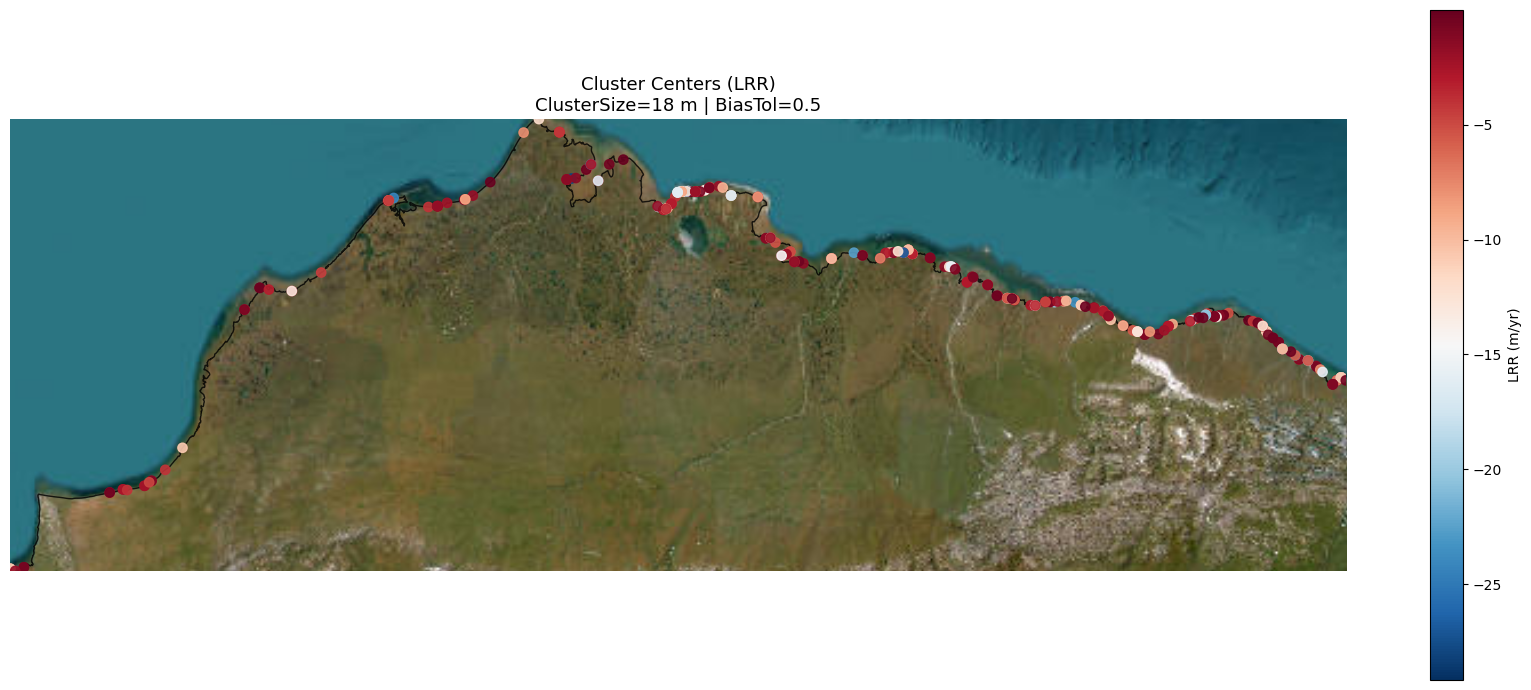

In [ ]:
# ============================================================
# 🧪 DEBUG MAP — Cluster Centers (NSM) with Auto-Zoom
# ============================================================

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# ------------------------------------------------------------
# USER SELECTION
# ------------------------------------------------------------
PLOT_CLUSTER_SIZE   = 18
PLOT_BIAS_TOLERANCE = 0.50

# Physically expected LRR range (m/yr)
LRR_MIN = -30.0
LRR_MAX = 0.0

# ------------------------------------------------------------
# LOAD RESULTS
# ------------------------------------------------------------
try:
    df_plot = combined.copy()
except NameError:
    df_plot = pd.read_csv(OUTFILE)

df_plot = df_plot.query(
    "ClusterSize == @PLOT_CLUSTER_SIZE and bias_tolerance == @PLOT_BIAS_TOLERANCE"
)

df_plot = df_plot.dropna(subset=["center_lat", "center_lon", "LRR"])

df_plot = df_plot.query(
    "LRR >= @LRR_MIN and LRR <= @LRR_MAX"
)
if df_plot.empty:
    raise ValueError("❌ No clusters match this selection.")

# ------------------------------------------------------------
# BUILD GeoDataFrame
# ------------------------------------------------------------
gdf_pts = gpd.GeoDataFrame(
    df_plot,
    geometry=gpd.points_from_xy(df_plot.center_lon, df_plot.center_lat),
    crs="EPSG:4326"
).to_crs(3857)

shoreline_plot = shoreline_gdf.to_crs(3857)

# ------------------------------------------------------------
# COMPUTE AUTO-ZOOM EXTENT
# ------------------------------------------------------------
xmin, ymin, xmax, ymax = gdf_pts.total_bounds

# padding (meters, since EPSG:3857)
pad = 500  # adjust if needed (e.g., 250, 1000)

xmin -= pad
xmax += pad
ymin -= pad
ymax += pad

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(17, 7))

gdf_pts.plot(
    ax=ax,
    column="LRR",
    cmap="RdBu_r",
    markersize=45,
    alpha=0.9,
    legend=True,
    legend_kwds={"label": "LRR (m/yr)"},
    zorder=3
)

shoreline_plot.plot(
    ax=ax,
    color="black",
    linewidth=1.0,
    alpha=0.8,
    zorder=2
)

# apply zoom
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    attribution=False
)

# ------------------------------------------------------------
# STYLING
# ------------------------------------------------------------
ax.set_title(
    f"Cluster Centers (LRR)\n"
    f"ClusterSize={PLOT_CLUSTER_SIZE} m | BiasTol={PLOT_BIAS_TOLERANCE}",
    fontsize=13
)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [ ]:
sfdsf

NameError: name 'sfdsf' is not defined

In [ ]:
# ============================================================
# CACHE WORKFLOW OUTPUTS PER (ClusterSize, BiasTolerance)
# ============================================================

WORKFLOW_CACHE = {}

for cs in CLUSTER_SIZES:
    for tol in BIAS_TOLERANCES:

        # print(f"⚙️ Running workflow: CS={cs} | BiasTol={tol}")

        (
            summary_fam,
            summary_clust,
            dataset_clean,
            clusters_gdf,
            selected_clusters,
            filtered_profiles,
            bias_summary,
            bias_df
        ) = run_workflow(
            track_id=TRACK_ID,
            dataset_raw=dataset_raw,
            shoreline_gdf=shoreline_gdf,
            CLUSTER_DISTANCE_M=cs,
            BIAS_TOLERANCE=tol,
            verbose=False
        )

        if selected_clusters is None or selected_clusters.empty:
            print("   ⚠️ No clusters — skipping cache")
            continue

        WORKFLOW_CACHE[(cs, tol)] = {
            "selected_clusters": selected_clusters,
            "filtered_profiles": filtered_profiles,
            "bias_df": bias_df
        }

print(f"\n✅ Cached {len(WORKFLOW_CACHE)} workflow setups.")


   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache
   ⚠️ No clusters — skipping cache

✅ Cached 0 workflow

In [ ]:
def debug_plot_reference_profile(
        filtered_profiles,
        selected_clusters,
        bias_df,
        cluster_id,
        gt_family,
        which="first",
        gap_threshold=40.0,
        atol=1e-3,
        cmap_name="tab20"
    ):
    """
    Debug plot for a single cluster showing:
        • All cycles that passed bias filtering
        • Reference-line elevation
        • Bluff crossings (retreat cycles)
        • Removed accretion cycles (in red)

    This function mirrors the logic in process_cluster_with_reference().
    """

    # -------------------------------------------------------------
    # 1. Locate cluster in selected_clusters
    # -------------------------------------------------------------
    cl = selected_clusters[
        (selected_clusters["gt_family"] == gt_family) &
        (selected_clusters["cluster_id"] == cluster_id)
    ]

    if cl.empty:
        print(f"❌ Cluster {gt_family}-{cluster_id} not found.")
        return None, None

    # Extract beam IDs
    raw_ids = cl.iloc[0]["beam_ids"]
    beam_ids = [
        (b[1] if isinstance(b, (tuple, list)) and len(b) > 1 else b)
        for b in (raw_ids if isinstance(raw_ids, (tuple, list)) else [raw_ids])
    ]
    beam_ids = [str(b).strip() for b in beam_ids]

    # -------------------------------------------------------------
    # 2. Filter PROFILES to this cluster + bias keeps
    # -------------------------------------------------------------
    df = filtered_profiles.copy()
    df["beam_id_str"] = df["beam_id"].astype(str).str.strip()

    fam_prof = df[
        (df["gt_family"] == gt_family) &
        (df["cluster_id"] == cluster_id) &
        (df["beam_id_str"].isin(beam_ids)) &
        (df["keep"] == True)
    ].copy()

    # Always include reference cycles
    ref_cycles = bias_df[
        (bias_df["gt_family"] == gt_family) &
        (bias_df["cluster_id"] == cluster_id) &
        (bias_df["is_ref"] == True)
    ][["beam_id", "acq_date"]].copy()

    if not ref_cycles.empty:
        ref_cycles["beam_id_str"] = ref_cycles["beam_id"].astype(str)
        ref_cycles["acq_date_norm"] = ref_cycles["acq_date"].dt.normalize()

        df["acq_date_norm"] = df["acq_date"].dt.normalize()

        ref_prof = df.merge(
            ref_cycles[["beam_id_str", "acq_date_norm"]],
            on=["beam_id_str", "acq_date_norm"],
            how="inner"
        )

        fam_prof = pd.concat([fam_prof, ref_prof], ignore_index=True)

    if fam_prof.empty:
        print("❌ No kept cycles to plot.")
        return None, None

    # -------------------------------------------------------------
    # 3. Compute reference elevation (y_ref)
    # -------------------------------------------------------------
    oldest_idx = fam_prof["acq_date"].idxmin()
    oldest_bid = fam_prof.loc[oldest_idx, "beam_id"]
    oldest_dt  = fam_prof.loc[oldest_idx, "acq_date"]

    ref_prof = fam_prof[
        (fam_prof["beam_id"] == oldest_bid) &
        (fam_prof["acq_date"] == oldest_dt)
    ]

    y_ref = float((ref_prof["h_li"].min() + ref_prof["h_li"].max()) / 2.0)

    # -------------------------------------------------------------
    # 4. Compute bluff_x / bluff_y for ALL cycles
    # -------------------------------------------------------------
    bluff_records = []

    for (bid, dt), prof in fam_prof.groupby(["beam_id", "acq_date"]):
        prof = prof.sort_values("distance_from_offshore").dropna(
            subset=["distance_from_offshore", "h_li"]
        )

        bx, by = find_bluff_by_reference(
            prof,
            y_ref,
            x_col="distance_from_offshore",
            y_col="h_li",
            which=which,
            gap_threshold=gap_threshold,
            atol=atol
        )

        if np.isfinite(bx) and np.isfinite(by):
            bluff_records.append({
                "beam_id": bid,
                "acq_date": dt,
                "bluff_x": float(bx),
                "bluff_y": float(by)
            })

    bluff_df = pd.DataFrame(bluff_records)

    if bluff_df.empty:
        print("❌ No bluff points computed.")
        return None, y_ref

    # -------------------------------------------------------------
    # 5. ACCRETION FILTERING (highlight removed cycles)
    # -------------------------------------------------------------
    # bluff_df = bluff_df.sort_values("acq_date").reset_index(drop=True)
    # bluff_df["delta_x"] = bluff_df["bluff_x"].diff()

    # removed = bluff_df[bluff_df["delta_x"] < 0].copy()
    # kept    = bluff_df[(bluff_df["delta_x"].isna()) | (bluff_df["delta_x"] >= 0)].copy()

    # if len(removed):
    #     print("===== REMOVED ACCRETION CYCLES =====")
    #     print(removed[["acq_date", "bluff_x", "delta_x"]])
    #     print("====================================")
    kept = bluff_df.copy() # no accretion filtering for debug plot // remove this line to re-enable

    # -------------------------------------------------------------
    # 6. Plot profiles
    # -------------------------------------------------------------
    cmap = plt.colormaps[cmap_name]
    unique_beams = sorted(fam_prof["beam_id_str"].unique())
    color_map = {beam: cmap(i) for i, beam in enumerate(unique_beams)}

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot each elevation profile
    for (bid, dt), g in fam_prof.groupby(["beam_id_str", "acq_date"]):
        g = g.sort_values("distance_from_offshore")
        date_str = dt.date().isoformat()
        color = color_map[bid]
        lw = 1.8

        # Highlight REF cycle
        if str(bid) == str(oldest_bid) and dt == oldest_dt:
            color = "black"
            lw = 3.2
            label = f"{date_str} (REF)"
        else:
            label = date_str

        ax.plot(
            g["distance_from_offshore"], g["h_li"],
            color=color, lw=lw, label=label
        )

    # -------------------------------------------------------------
    # 7. Plot reference line + bluff crossings
    # -------------------------------------------------------------
    ax.axhline(y_ref, color="red", linestyle="--", lw=2, label=f"Ref = {y_ref:.2f} m")

    # Bluff crossings (kept)
    if not kept.empty:
        ax.scatter(
            kept["bluff_x"], kept["bluff_y"],
            s=60, color="orange",
            label="Bluff crossings (kept)"
        )

    # Bluff crossings (removed accretion)
    # if not removed.empty:
    #     ax.scatter(
    #         removed["bluff_x"], removed["bluff_y"],
    #         s=70, color="red", marker="x",
    #         label="Removed (accretion)"
    #     )

    # -------------------------------------------------------------
    # 8. Final plot formatting
    # -------------------------------------------------------------
    ax.set_title(f"DEBUG PROFILE — Cluster {cluster_id} — {gt_family.upper()}")
    ax.set_xlabel("Distance from offshore (m)")
    ax.set_ylabel("Elevation (m)")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.legend(frameon=False, fontsize=8)
    plt.tight_layout()
    plt.show()

    return kept, y_ref


In [ ]:
# ============================================================
# SETUP-AWARE DEBUG PLOT WRAPPER
# ============================================================

def debug_plot_by_setup(
    cluster_size,
    bias_tolerance,
    cluster_id,
    gt_family,
    which="first",
    gap_threshold=40.0,
    atol=1e-3
):
    """
    Debug plot WITHOUT re-running the workflow.
    """

    key = (cluster_size, bias_tolerance)

    if key not in WORKFLOW_CACHE:
        raise KeyError(
            f"❌ Setup (CS={cluster_size}, BiasTol={bias_tolerance}) "
            f"not found in cache."
        )

    data = WORKFLOW_CACHE[key]

    return debug_plot_reference_profile(
        filtered_profiles=data["filtered_profiles"],
        selected_clusters=data["selected_clusters"],
        bias_df=data["bias_df"],
        cluster_id=cluster_id,
        gt_family=gt_family,
        which=which,
        gap_threshold=gap_threshold,
        atol=atol
    )


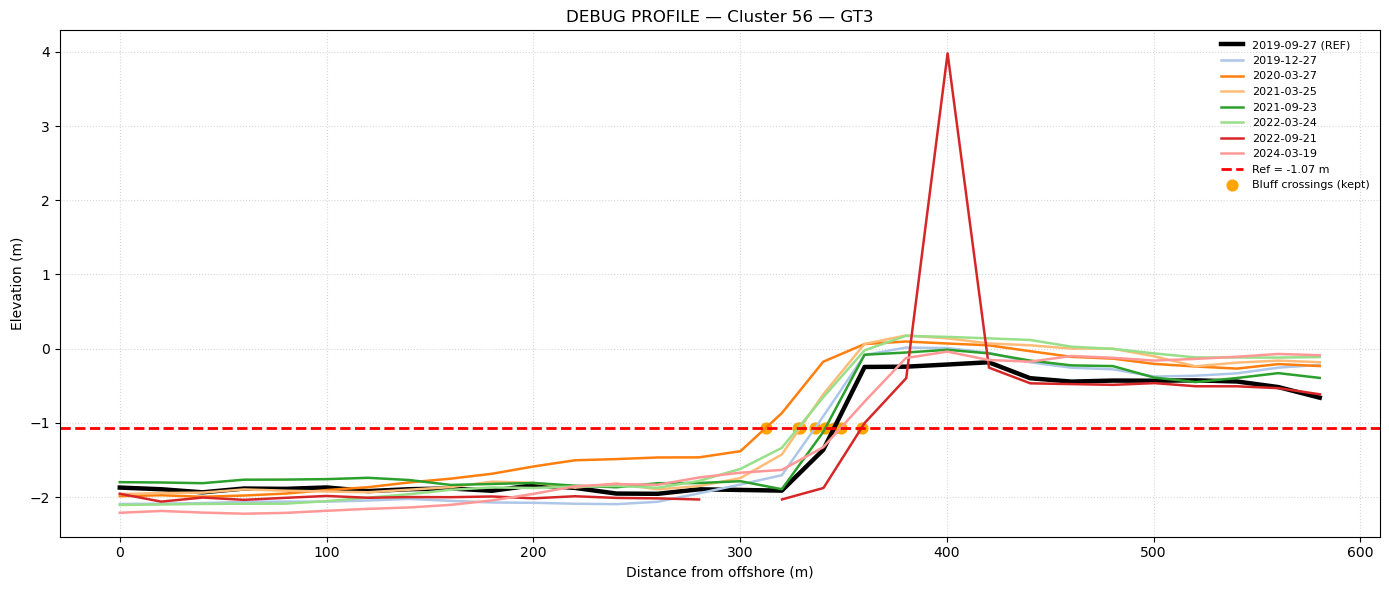

(                    beam_id   acq_date     bluff_x   bluff_y
 0  ATL06_0015_gt3l_20190927 2019-09-27  345.514563 -1.069692
 1  ATL06_0015_gt3l_20191227 2019-12-27  336.279194 -1.069692
 2  ATL06_0015_gt3l_20200327 2020-03-27  312.388226 -1.069692
 3  ATL06_0015_gt3l_20210325 2021-03-25  329.030375 -1.069692
 4  ATL06_0015_gt3l_20210923 2021-09-23  341.263013 -1.069692
 5  ATL06_0015_gt3l_20220324 2022-03-24  328.076986 -1.069692
 6  ATL06_0015_gt3l_20220921 2022-09-21  358.768285 -1.069692
 7  ATL06_0015_gt3l_20240319 2024-03-19  348.656658 -1.069692,
 -1.0696920678019526)

In [ ]:
# Example debug call
debug_plot_by_setup(
    cluster_size=42,
    bias_tolerance=0.25,
    cluster_id= 56,
    gt_family="gt3",
    which="first"
)


In [ ]:
# --- Debug plot: selected vs all clusters (using kept points, no legend) -------

def plot_selected_clusters(clusters_gdf, selected_clusters, fam, pts_gdf=None):
    """
    Visual debugging of clustering step:
        • All clusters = gray outlines
        • Selected clusters = green outlines
        • Kept points (after preprocessing) = light gray dots

    fam       → "gt1", "gt2", or "gt3"
    pts_gdf   → dataset_raw (kept beams) recommended
    """

    if clusters_gdf is None or clusters_gdf.empty:
        print("[WARN] clusters_gdf is empty.")
        return

    # --- Filter for requested family ---
    fam_clusters = clusters_gdf.loc[clusters_gdf["gt_family"] == fam].copy()
    fam_selected = selected_clusters.loc[selected_clusters["gt_family"] == fam].copy()

    if fam_clusters.empty:
        print(f"[INFO] No clusters for family '{fam}'.")
        return

    # --- Prepare beam points source (kept beams after preprocessing) ---
    if pts_gdf is None:
        pts_src = dataset_raw if "dataset_raw" in globals() else None
    else:
        pts_src = pts_gdf

    # Ensure UTM for safe plotting
    fam_clusters = fam_clusters.to_crs(UTM_EPSG)
    fam_selected = fam_selected.to_crs(UTM_EPSG)
    if isinstance(pts_src, gpd.GeoDataFrame) and not pts_src.empty:
        pts_src = pts_src.to_crs(UTM_EPSG)

    # ------------------------------------------------------------------
    #  Plot
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(16, 18))

    # 1) ALL clusters (light gray)
    fam_clusters.boundary.plot(ax=ax, color="lightgray", linewidth=1)

    # 2) Kept beam points for this family
    if isinstance(pts_src, gpd.GeoDataFrame):
        fam_pts = pts_src.loc[pts_src["gt_family"] == fam]
        if not fam_pts.empty:
            fam_pts.plot(ax=ax, color="silver", markersize=3, alpha=0.7)

    # 3) SELECTED clusters (green)
    if not fam_selected.empty:
        fam_selected.boundary.plot(ax=ax, color="green", linewidth=2)

        # Label each selected cluster ID
        for _, row in fam_selected.iterrows():
            geom = row.geometry
            if geom is None:
                continue
            cx = geom.centroid.x
            cy = geom.centroid.y
            ax.text(
                cx, cy,
                str(row["cluster_id"]),
                fontsize=12,
                color="red",
                ha="center", va="center"
            )

    ax.set_title(f"Selected Clusters — {fam.upper()}",
                 fontsize=16)
    ax.set_aspect("equal", "box")
    ax.grid(True, linestyle=":", alpha=0.4)

    plt.tight_layout()
    plt.show()


# # --- Example usage ---
# plot_selected_clusters(
#     clusters_gdf,
#     selected_clusters,
#     fam="gt2",
#     pts_gdf=dataset_raw  # KEPT points
# )


In [ ]:
# ============================================================
# SETUP-AWARE CLUSTER SELECTION DEBUG PLOT
# ============================================================

def plot_selected_clusters_by_setup(
    cluster_size,
    bias_tolerance,
    fam,
    pts_gdf=None
):
    """
    Plot selected vs all clusters for a given setup WITHOUT re-running workflow.
    """

    key = (cluster_size, bias_tolerance)

    if key not in WORKFLOW_CACHE:
        raise KeyError(
            f"❌ Setup CS={cluster_size}, BiasTol={bias_tolerance} not cached."
        )

    data = WORKFLOW_CACHE[key]

    plot_selected_clusters(
        clusters_gdf=data["clusters_gdf"],
        selected_clusters=data["selected_clusters"],
        fam=fam,
        pts_gdf=pts_gdf
    )


In [ ]:
plot_selected_clusters_by_setup(
    cluster_size=12,
    bias_tolerance=0.5,
    fam="gt1",
    pts_gdf=dataset_raw
)


KeyError: 'clusters_gdf'